<h1>
    <center>
        Observing System Simulation Experiments (OSSEs)<br><br>
        Preparation of assets for Djeutchouang et al. (2022)
    </center>
</h1>

## Load the required dependencies


### Import packages

In [1]:
#%pylab inline
%load_ext autoreload
%matplotlib inline

import os
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_style('ticks')

### Warnings managers
import warnings
warnings.simplefilter("ignore")

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

###  Set the working directory

In [2]:
pwd

'/Volumes/GoogleDrive/My Drive/Projects/Thesis/Laique Merlin Djeutchouang - PhD/manuscripts/osse-v1/code'

In [3]:
##### Set the base of the working directory
os.chdir("../")    

## Data Preprocessing

### Load the required data


In [4]:
### Save to the disk 
input_fname = "./data/dataset_of_osse_results_paper1.nc"

osse_xds = xr.open_dataset(input_fname)
osse_xds

<xarray.Dataset>
Dimensions:     (experiment: 9, time: 365, lat: 170, lon: 241)
Coordinates:
  * time        (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-12-30
  * lat         (lat) float64 -49.95 -49.9 -49.84 ... -40.16 -40.09 -40.03
  * lon         (lon) float64 -10.0 -9.917 -9.833 -9.75 ... 9.833 9.917 10.0
  * experiment  (experiment) object 'SHIP(smr)' ... 'SHIP(smr) + nUSV'
Data variables:
    spco2_est   (experiment, time, lat, lon) float32 ...
    spco2_obs   (time, lat, lon) float32 ...
Attributes:
    description:  This is the dataset of the results discussed in Djeutchouan...

In [5]:
##### Get the pCO2 estimates per experiments 
spco2_est = osse_xds.spco2_est.copy()
spco2_obs = osse_xds.spco2_obs.copy()
spco2_est

<xarray.DataArray 'spco2_est' (experiment: 9, time: 365, lat: 170, lon: 241)>
[134586450 values with dtype=float32]
Coordinates:
  * time        (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-12-30
  * lat         (lat) float64 -49.95 -49.9 -49.84 ... -40.16 -40.09 -40.03
  * lon         (lon) float64 -10.0 -9.917 -9.833 -9.75 ... 9.833 9.917 10.0
  * experiment  (experiment) object 'SHIP(smr)' ... 'SHIP(smr) + nUSV'
Attributes:
    long_name:      Partial pressure of CO2 (pCO2) at the surface ocean
    standard_name:  Surface ocean pCO2
    units:          µatm
    description:    Estimates of surface ocean pCO2 using a two-member ensemb...

In [6]:
### Get BP12's SAF for SIME sub-domain
saf_coords = pd.read_csv("./data/subantarctic_front_coordinates_osse_paper1.csv")
bp12_saf = pd.read_csv("./data/subantarctic_front_BP12_model.csv")
lon_safBP12 = bp12_saf.lon_safBP12.values
lat_safBP12 = bp12_saf.lat_safBP12.values

In [8]:
### Load the SHIP tracks 
ship_tracks = pd.read_csv("./data/ship_tracks_osse_paper1.csv")

### Some preprocessing tools

In [9]:
from string import ascii_lowercase as asci

def number_figures(axes, pos=None, labels=asci, ftsize=15, braces=True, **text_kwargs):

    depth = lambda L: isinstance(L, list) and max(map(depth, L)) + 1

    if pos is None:
        pos = [[0.99, 0.93]] * len(axes)
    elif (depth(pos) == 1) & (len(pos) == 2):
        pos = [list(pos)] * len(axes)
    elif (depth(pos) != 2) & (len(pos) != len(axes)):
        raise (Exception, 'check the position is the right format')
    
    for c, ax in enumerate(axes):
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()

        w = x1 - x0
        h = y1 - y0
        x = x0 + w * pos[c][0]
        y = y0 + h * pos[c][1]

        t = '%s' % labels[c]
        if braces:
            t = '(%s)' % (t)
        ax.text(x, y, t, fontsize=ftsize, **text_kwargs)

def number_figures0(axes, pos=None, labels=asci, braces=True, **text_kwargs):

    depth = lambda L: isinstance(L, list) and max(map(depth, L)) + 1

    if pos is None:
        pos = [[0.99, 0.93]] * len(axes)
    elif (depth(pos) == 1) & (len(pos) == 2):
        pos = [list(pos)] * len(axes)
    elif (depth(pos) != 2) & (len(pos) != len(axes)):
        raise (Exception, 'check the position is the right format')
    
    for c, ax in enumerate(axes):
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()

        w = x1 - x0
        h = y1 - y0
        x = x0 + w * pos[c][0]
        y = y0 + h * pos[c][1]

        t = '%s' % labels[c]
        if braces:
            t = '(%s)' % (t)
        ax.text(x, y, t, **text_kwargs)

In [10]:
def get_SAF_front(xda):
    x_val = xda.lon.values
    y_val = xda.lat.values
    z_val = xda.values
    
    cons = plt.contour(x_val, y_val, z_val, levels=1)
    plt.close()
    SA_front = cons.collections[1].get_paths()[0]  # grab the 1st path
    coord_SAF = SA_front.vertices
    
    return coord_SAF

In [11]:
def make_mn_sc(xda):
    clim = xda.groupby("time.month").mean("time")
    ###
    mean_sc = clim.mean(["lat", "lon"]).to_series()
    std_sc = clim.std(["lat", "lon"]).to_series()
    ###
    index = xda.time.dt.month.to_dataframe().drop_duplicates().index.strftime('%b')
    output = pd.DataFrame({"mean": mean_sc.values,
                           "std": std_sc.values}, index=index)
    return output

In [12]:
def split_data_saz_pfz(xds, saf_arr=saf_coords):
    
    df = xds.to_dataframe().reset_index()
    saf_arr = saf_arr.values
    
    ### Get the SAZ data
    xds_saz = pd.concat([df[((df.lon==val[0])&(df.lat>=val[1]))] for val in saf_arr],
                        ignore_index=True)
    xds_saz = xds_saz.set_index(["time", "lat", "lon"]).sort_index()
    xds_saz = xds_saz.to_xarray().to_array(name=xds_saz.columns[-1])

    ### Get the PFZ data
    xds_pfz = pd.concat([df[((df.lon==val[0])&(df.lat<=val[1]))] for val in saf_arr],
                        ignore_index=True)
    xds_pfz = xds_pfz.set_index(["time", "lat", "lon"]).sort_index()
    xds_pfz = xds_pfz.to_xarray().to_array(name=xds_pfz.columns[-1])
    
    return xds_saz, xds_pfz

In [13]:
def product_mn_sc(xdarr, clim_flag=False):
    import pandas as pd
    
    if clim_flag:
        yr_start, yr_end = 2008, 2008
        xdarr.assign_coords(time = pd.date_range(f"{yr_start}-01-01", f"{yr_end}-12-31", freq="M"))
        xdarr["time"] = pd.date_range(f"{yr_start}-01-01", f"{yr_end}-12-31", freq="M")
    
    clim = xdarr.groupby("time.month").mean("time")
    ###
    mean_sc = clim.mean(["lat", "lon"]).to_series()
    std_sc = clim.std(["lat", "lon"]).to_series()
    ###
    index = xdarr.time.dt.month.to_dataframe().drop_duplicates().index.strftime('%b')
    output = pd.DataFrame({"mean": mean_sc.values,
                           "std": std_sc.values}, index=index)
    return output

def split_product_saz_pfz(xds):
    ### Get the SAZ data
    xds_saz = xds.where(xds.lat>=-44.39)

    ### Get the PFZ data
    xds_pfz = xds.where(xds.lat<-44.39)
    
    return xds_saz, xds_pfz

### Calculate the mean seasonal cycles

In [14]:
####### BP12 model pCO2 
### SC in the whole domain 
mean_sc = make_mn_sc(spco2_obs)

### Split the data into SAZ and PFZ
xda_saz, xda_pfz = split_data_saz_pfz(xds=spco2_obs)

# SC in the SAZ
mean_sc_saz = make_mn_sc(xda_saz)

# SC in the PFZ
mean_sc_pfz = make_mn_sc(xda_pfz)

### Mean per domain
mean_dom = spco2_obs.mean().values.item()
mean_saz = xda_saz.mean().values.item()
mean_pfz = xda_pfz.mean().values.item()

mean_dom, mean_saz, mean_pfz

(368.1527404785156, 362.8625183105469, 371.950439453125)

In [15]:
####### CSIR-ML6-v2021 
### Load the data 
input_fname = "./data/csir-ml6_v2021_osse_v1.nc"
spco2_ml6_v21_osse1 = xr.open_dataarray(input_fname)

### SC in the whole domain 
ml6_mean_sc = make_mn_sc(spco2_ml6_v21_osse1)

### Split the data into SAZ and PFZ
ml6_xda_saz, ml6_xda_pfz = split_data_saz_pfz(spco2_ml6_v21_osse1)

# SC in the SAZ
ml6_mean_sc_saz = make_mn_sc(ml6_xda_saz)

# SC in the PFZ
ml6_mean_sc_pfz = make_mn_sc(ml6_xda_pfz)

In [16]:
#######  MPI-SOM-FNN-v2020
###  Load the data
input_fname = "./data/mpi-som-fnn_v2020_osse_v1.nc"
spco2_mpi_v20_osse1 = xr.open_dataarray(input_fname)

### SC in the whole domain 
mpi_mean_sc = product_mn_sc(spco2_mpi_v20_osse1, clim_flag=True)

##### Split the data into SAZ and PFZ
mpi_xda_saz, mpi_xda_pfz = split_product_saz_pfz(spco2_mpi_v20_osse1)

##### SC in the north of the domain (SAZ) 
mpi_mean_sc_saz = product_mn_sc(mpi_xda_saz, clim_flag=True)

##### SC in the south of the domain (PFZ) 
mpi_mean_sc_pfz = product_mn_sc(mpi_xda_pfz, clim_flag=True)

<h2>
    Figures
</h2>

<h3>
    Visualization Tools
</h3>


In [17]:
def plot_ann_mean_sc(xda, sc_domain, sc_saz, sc_pfz):
    ####### Get the data
    ### Domain
    mean_sc = sc_domain["mean"]
    std_sc = sc_domain["std"]
    ### SAZ
    mean_sc_saz = sc_saz["mean"]
    std_sc_saz = sc_saz["std"]
    ### PFZ
    mean_sc_pfz = sc_pfz["mean"]
    std_sc_pfz = sc_pfz["std"]
    
    ### Get pCO2 ndarray 
    xda = xda.mean("time")
    lat_vals = xda.lat.values
    lon_vals = xda.lon.values
    pco2_vals = xda.values

    ##### Mean annual state of PCO2 Option 2 
    fig = plt.figure(figsize=[18,5], dpi=90, constrained_layout=True)
    grids = mpl.gridspec.GridSpec(1, 2, wspace=0.18, width_ratios=[2.2, 1.8]) #, width_ratios=[2.25, 1.75]
    ax1 = fig.add_subplot(grids[0])
    ax2 = fig.add_subplot(grids[1])
    ax = np.array([[ax1, ax2]])
    ax = ax.reshape(-1)
    ### Plot the mean annual pCO2 
    kwargs = dict(vmin=350, vmax=380, cmap="turbo", norm=mpl.colors.PowerNorm(gamma=1), zorder=-1)
    mesh = ax1.pcolormesh(lon_vals, lat_vals, pco2_vals, **kwargs)
    cbar_ax = fig.add_axes([0.13, -0.1, 0.75, 0.08])
    cb = fig.colorbar(mesh, cax=cbar_ax, pad=0.15, extend="max", orientation="horizontal")
    cb.set_label("Surface ocean $p$CO$_2$ [$\mu$atm]", fontsize=20)

    ## Add BP12's SAF
    ax1.plot(lon_safBP12, lat_safBP12, c='#f7022a', lw=2.75, ls="--")

    ### Plot mean SC of pCO2
    # Whole domain
    mean_sc.plot(ax=ax2, lw=2.25, c="#1b2431", label="whole domain")
    ax2.fill_between(mean_sc.index, mean_sc-std_sc,
                     mean_sc+std_sc, alpha=0.3, facecolor="#1b2431")
    ax2.hlines(y=mean_dom, xmin=0, xmax=11, alpha=0.75, lw=1.75, ls="--", color="#1b2431")
    # SAZ
    mean_sc_saz.plot(ax=ax2, lw=2.25, c="#1d5dec", label="SAZ")
    ax2.fill_between(mean_sc_saz.index, mean_sc_saz-std_sc_saz,
                     mean_sc_saz+std_sc_saz, alpha=0.3, facecolor="#1d5dec")
    ax2.hlines(y=mean_saz, xmin=0, xmax=11, alpha=0.75, lw=1.75, ls="--", color="#1d5dec")
    # PFZ
    mean_sc_pfz.plot(ax=ax2, lw=2.25, c="#fe420f", label="PFZ")
    ax2.fill_between(mean_sc_pfz.index, mean_sc_pfz-std_sc_pfz,
                     mean_sc_pfz+std_sc_pfz, alpha=0.3, facecolor="#fe420f")
    ax2.hlines(y=mean_pfz, xmin=0, xmax=11, alpha=0.75, lw=1.75, ls="--", color="#fe420f")
    #
    ax2.legend()
    #
    # start, end = ax2.get_ylim()
    start, end = 350, 390
    ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%0.0f"))
    ax2.yaxis.set_ticks(np.arange(start, end+1, 5.0))
    ax2.set_ylabel("Surface ocean $p$CO$_2$ [$\mu$atm]")
    #
    ax2.xaxis.set_ticks(mean_sc.index)
    ax2.set_xticklabels(mean_sc.index)
    ax2.set_xlabel("")
    #
    start, end = ax1.get_ylim()
    ax1.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%0.0f"))
    ax1.yaxis.set_ticks(np.arange(round(start), round(end)+0.01, 2.0))

    #
    ax2.grid(c="#d8dcd6")
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    #
    ax1.set_xlabel("lon")
    ax1.set_ylabel("lat");
    ### Number/label the graphs
    number_figures([ax1, ax2], pos=[0.005,1.05], braces=True)
    # number_figures([ax2], pos=[0.9, 0.93], labels=["b"], braces=True)
    txt_kwargs = {"fontsize": 19, "c": "#03012d"}
    number_figures0([ax1], pos=[0.3, 0.8], labels=["SAZ"], braces=False, **txt_kwargs)
    number_figures0([ax1], pos=[0.3, 0.3], labels=["PFZ"], braces=False, **txt_kwargs)
    txt_kwargs1 = {"fontsize": 19, "c": "#f7022a"}
    number_figures0([ax1], pos=[0.03, 0.62], labels=["SAF"], braces=False, **txt_kwargs1)
   
    return fig

In [18]:
def get_mbe(raw_pco2, pred_pco2):
    
    ### Calculate the difference
    return (pred_pco2 - raw_pco2).mean("time")

def get_sc_anom(xda_raw, xda_est):
    sc_raw = make_mn_sc(xda_raw)
    sc_est = make_mn_sc(xda_est)
    sc_anom = sc_est["mean"] - sc_raw["mean"]
    
    return sc_anom

In [19]:
def plot_mean_sc(sc_domain, sc_saz, sc_pfz, ax):
    ####### Get the data
    ### Domain
    mean_sc = sc_domain["mean"]
    std_sc = sc_domain["std"]
    ### SAZ
    mean_sc_saz = sc_saz["mean"]
    std_sc_saz = sc_saz["std"]
    ### PFZ
    mean_sc_pfz = sc_pfz["mean"]
    std_sc_pfz = sc_pfz["std"]

    ### Plot mean SC of pCO2
    # Whole domain
    mean_sc.plot(ax=ax, lw=2.25, c="#1b2431", label="whole domain")
    ax.fill_between(mean_sc.index, mean_sc-std_sc,
                     mean_sc+std_sc, alpha=0.3, facecolor="#1b2431")
    # SAZ
    mean_sc_saz.plot(ax=ax, lw=2.25, c="#1d5dec", label="SAZ")
    ax.fill_between(mean_sc_saz.index, mean_sc_saz-std_sc_saz,
                     mean_sc_saz+std_sc_saz, alpha=0.3, facecolor="#1d5dec")
    # PFZ
    mean_sc_pfz.plot(ax=ax, lw=2.25, c="#fe420f", label="PFZ")
    ax.fill_between(mean_sc_pfz.index, mean_sc_pfz-std_sc_pfz,
                     mean_sc_pfz+std_sc_pfz, alpha=0.3, facecolor="#fe420f")
    
    #
    # start, end = ax2.get_ylim()
    start, end = 330, 395
    ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%0.0f"))
    ax.yaxis.set_ticks(np.arange(start, end+1, 7.5))
    
    ax.set_ylabel("Surface ocean $p$CO$_2$ [$\mu$atm]")
    #
    ax.xaxis.set_ticks(mean_sc.index)
    ax.set_xticklabels(mean_sc.index)
    ax.set_xlabel("")
    #
    ax.grid(c="#d8dcd6")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

### Model vs data products: the mean seasonal cycle of $p\text{CO}_{2}$

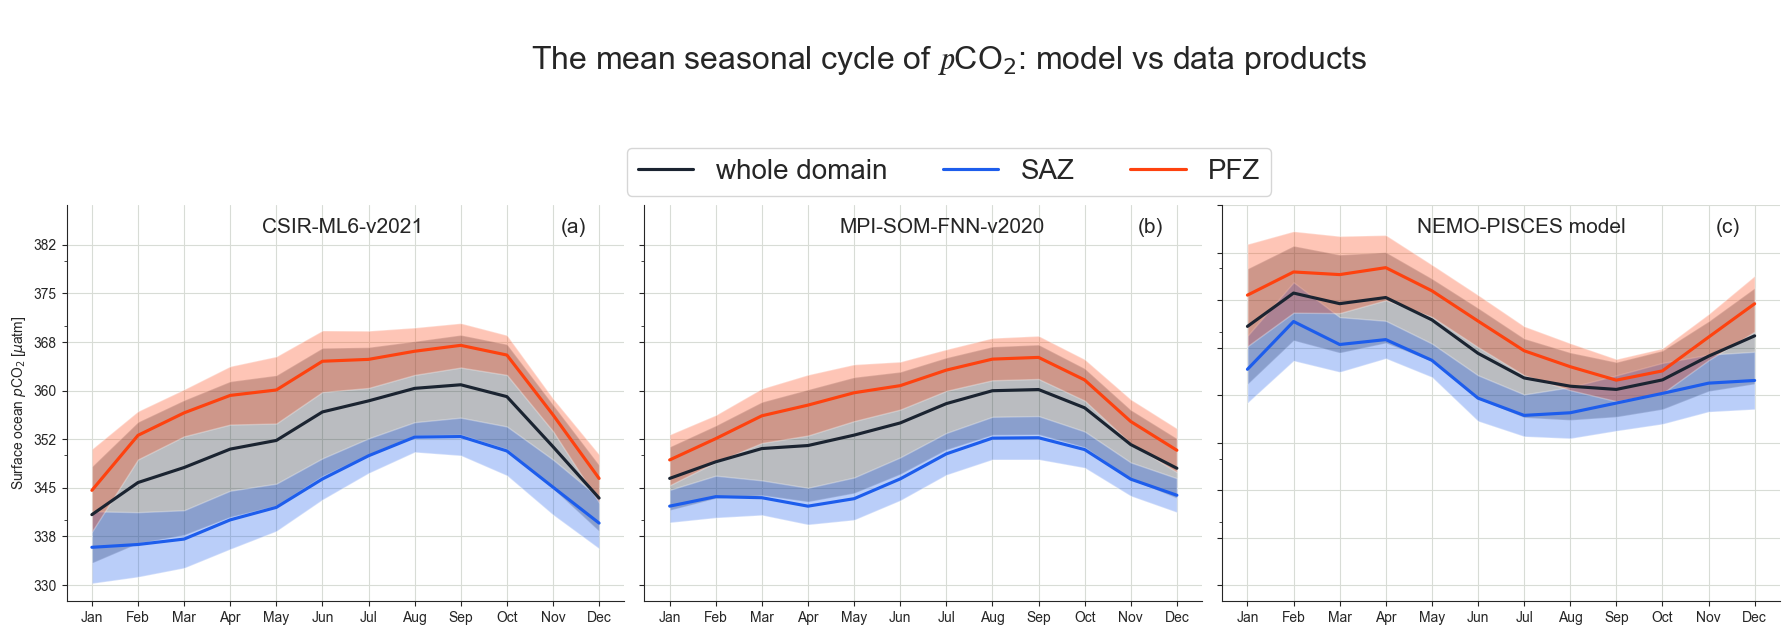

In [21]:
fig, ax = plt.subplots(1, 3, figsize=[18,4.5], dpi=100, sharey=True)


plot_mean_sc(ml6_mean_sc,
             ml6_mean_sc_saz,
             ml6_mean_sc_pfz, ax[0])

plot_mean_sc(mpi_mean_sc,
             mpi_mean_sc_saz,
             mpi_mean_sc_pfz, ax[1])

plot_mean_sc(mean_sc,
             mean_sc_saz,
             mean_sc_pfz, ax[2])

lgd_labels = ["whole domain", "SAZ", "PFZ"]
lines = list(plt.gca().get_lines())
fig.legend(lines, lgd_labels, bbox_to_anchor=(0.53, 1.125),
           fontsize=20, ncol=3, loc="upper center")

# number_figures(ax, pos=[0.005,0.93], braces=True)
number_figures(ax, pos=[0.885,0.93], braces=True)
labels = ["CSIR-ML6-v2021", "MPI-SOM-FNN-v2020", "NEMO-PISCES model"]
number_figures(ax, pos=[0.35,0.93], labels=labels, braces=False)
fig.tight_layout()

fig.suptitle("\nThe mean seasonal cycle of $𝑝$CO$_2$: model vs data products",
             x=0.53, y=1.4, fontsize=23);

# Save the figure
# sfig = "spCO2_model_vs_product_mean_seasonal_cycles_osse_paper1.pdf"
# fig.savefig(f"./figures/{sfig}", bbox_inches="tight", dpi=300);

### Mean State Characteristics of the Domain

Annual mean seasonal cycle for the domain

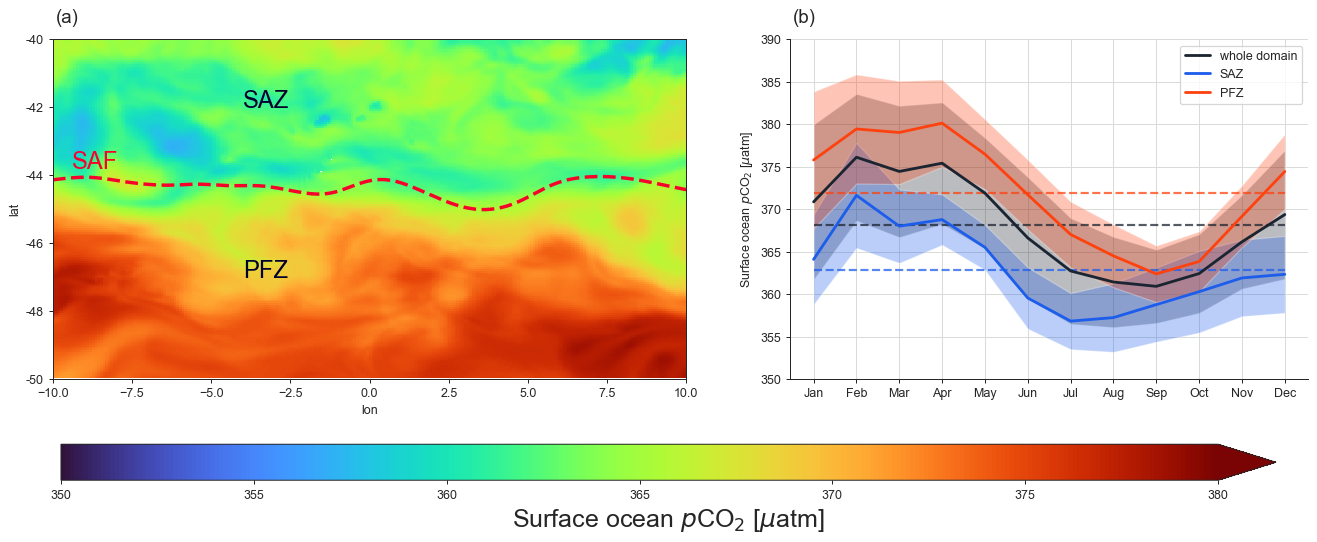

In [22]:
fig = plot_ann_mean_sc(spco2_obs, mean_sc,
                       mean_sc_saz, mean_sc_pfz)


### Save the figure
# sfig = "spCO2_model_annual_mean_and_seasonal_cycles_osse_paper1.pdf"
# fig.savefig(f"./figures/{sfig}", bbox_inches="tight", dpi=300)

### Spatial Anomalies


#### SHIP experiment

In [23]:
def anom_and_ships1(dict_expts, spco2_obs,
                    cbr_limit=20, yaxis_scale=10,
                    ftsize=13, ncols=2, lgdsize=15):
    ### Limits
    
    ### Make a user-defined colormap: Red-White-Blue palette
    #BuWiRed = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName", ["b", "w", "r"])
    BuWiRed = "RdBu_r"
    ### Make a normalizer that will map the time values
    cnorm = mpl.colors.Normalize(vmin=-cbr_limit, vmax=cbr_limit)
    #### Turn these into an object that can be used to map time values to colors and
    # can be passed to plt.colorbar().
    cpick = mpl.cm.ScalarMappable(norm=cnorm, cmap=BuWiRed)
    cpick.set_array([])
    
    #fig = plt.figure(figsize=[17,12], dpi=300)
    fig = plt.figure(figsize=[20, 12], dpi=300, constrained_layout=True)
    grid = mpl.gridspec.GridSpec(2, 2, wspace=0.175, hspace=0.3, width_ratios=[1.85, 2.15])
    ax = [fig.add_subplot(grid[0, 0]),
          fig.add_subplot(grid[1, 0]),
          fig.add_subplot(grid[:, 1])]
    
    ### Optional params. for plotting
    kwargs = dict(add_colorbar=False, vmin=-cbr_limit, vmax=cbr_limit, cmap=BuWiRed)
    
    sc_anoms = {}
    imgs = []
    for i, expt in enumerate(dict_expts.keys()):
        xda_mbe = get_mbe(spco2_obs, dict_expts[expt])
        img = xda_mbe.plot.pcolormesh(ax=ax[i], **kwargs)
        imgs.append(img)
        sc_anoms[expt] = get_sc_anom(spco2_obs, dict_expts[expt])
        #ax[i].set_title(f"\n{expt}")
        ax[i].axes.axis('tight')
        ax[i].set_xlabel("")
        ax[i].set_ylabel("")

    cbr = fig.colorbar(cpick, ax=ax,
                       orientation="horizontal",
                       extend="both", shrink=0.95, pad=0.08)
    cbr.set_label("Anomalies/mean bias error (MBE): $p$CO$_{2}^{est}-BP12$ [$\mu$atm]", fontsize=16)
    ax[0].set_ylabel("lat")
    ax[1].set_xlabel("lon")
    ax[1].set_ylabel("lat")
    
    ### Plot the SC anomalies
    df = pd.DataFrame(sc_anoms, index=sc_anoms[expt].index)
    #df.plot(ax=ax[-1], lw=3.25)
    
    for key in sc_anoms.keys():
        sc_anoms[key].plot(ax=ax[-1], lw=2.25, label=key)
    
    #start, end = ax[-1].get_ylim()
    ax[-1].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%0.0f"))
    start, end = -yaxis_scale, yaxis_scale+1
    ax[-1].yaxis.set_ticks(np.arange(start, end, 5))
    ax[-1].set_ylabel("$p$CO$_2$ SC anomalies [$\mu$atm]")
    #
    ax[-1].xaxis.set_ticks(np.arange(df.shape[0]))
    ax[-1].set_xticklabels(df.index)
    ax[-1].set_xlabel("")
    ax[-1].grid(c="#d8dcd6")
    ax[-1].legend(ncol=ncols, loc=0, fontsize=lgdsize)
    ax[-1].spines["top"].set_visible(False)
    ax[-1].spines["right"].set_visible(False)
        
    #ax[-1].set_facecolor("#758da3");
    
    ### Number/label the graphs
    number_figures(ax[:2], pos=[0.005,1.05], braces=True)
    number_figures([ax[-1]], pos=[0.005,1.0225], labels=["c"], braces=True)
    number_figures(ax[:2], pos=[0.075,1.05], labels=df.columns, ftsize=ftsize, braces=False)
    
    return fig

In [24]:
def anom_and_ships2(dict_expts, spco2_obs,
                    ship_tracks, cbr_limit=20,
                    yaxis_scale=10, ftsize=13,
                    ncols=2, lgdsize=15):
    ### Limits
    
    ### Make a user-defined colormap: Red-White-Blue palette
    #BuWiRed = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName", ["b", "w", "r"])
    BuWiRed = "RdBu_r"
    ### Make a normalizer that will map the time values
    cnorm = mpl.colors.Normalize(vmin=-cbr_limit, vmax=cbr_limit)
    #### Turn these into an object that can be used to map time values to colors and
    # can be passed to plt.colorbar().
    cpick = mpl.cm.ScalarMappable(norm=cnorm, cmap=BuWiRed)
    cpick.set_array([])
    
    #fig = plt.figure(figsize=[17,12], dpi=300)
    fig = plt.figure(figsize=[20, 12], dpi=300, constrained_layout=True)
    grid = mpl.gridspec.GridSpec(2, 2, wspace=0.175, hspace=0.3, width_ratios=[1.85, 2.15])
    ax = [fig.add_subplot(grid[0, 0]),
          fig.add_subplot(grid[1, 0]),
          fig.add_subplot(grid[:, 1])]
    
    ### Optional params. for plotting
    kwargs = dict(add_colorbar=False, vmin=-cbr_limit, vmax=cbr_limit, cmap=BuWiRed)
    
    sc_anoms = {}
    imgs = []
    for i, expt in enumerate(dict_expts.keys()):
        xda_mbe = get_mbe(spco2_obs, dict_expts[expt])
        img = xda_mbe.plot.pcolormesh(ax=ax[i], **kwargs)
        imgs.append(img)
        sc_anoms[expt] = get_sc_anom(spco2_obs, dict_expts[expt])
        #ax[i].set_title(f"\n{expt}")
        ax[i].axes.axis('tight')
        ax[i].set_xlabel("")
        ax[i].set_ylabel("")

    cbr = fig.colorbar(cpick, ax=ax,
                       orientation="horizontal",
                       extend="both", shrink=0.95, pad=0.08)
    cbr.set_label("Anomalies/mean bias error (MBE): $p$CO$_{2}^{est}-BP12$ [$\mu$atm]", fontsize=16)
    ax[0].set_ylabel("lat")
    ax[1].set_xlabel("lon")
    ax[1].set_ylabel("lat")
    
    ### Plot the SC anomalies
    df = pd.DataFrame(sc_anoms, index=sc_anoms[expt].index)
    #df.plot(ax=ax[-1], lw=3.25)
    
    for key in sc_anoms.keys():
        sc_anoms[key].plot(ax=ax[-1], lw=2.25, label=key)
    
    #start, end = ax[-1].get_ylim()
    ax[-1].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%0.0f"))
    start, end = -yaxis_scale, yaxis_scale+1
    ax[-1].yaxis.set_ticks(np.arange(start, end, 5))
    ax[-1].set_ylabel("$p$CO$_2$ SC anomalies [$\mu$atm]")
    #
    ax[-1].xaxis.set_ticks(np.arange(df.shape[0]))
    ax[-1].set_xticklabels(df.index)
    ax[-1].set_xlabel("")
    ax[-1].grid(c="#d8dcd6")
    ax[-1].legend(ncol=ncols, loc=0, fontsize=lgdsize)
    ax[-1].spines["top"].set_visible(False)
    ax[-1].spines["right"].set_visible(False)
        
    #ax[-1].set_facecolor("#758da3");
    ### Ship tracks
    ax[0].scatter(ship_tracks.lon, ship_tracks.lat,
                  marker="s", s=5, c="gray")
    ax[1].scatter(ship_tracks.lon, ship_tracks.lat,
                  marker="s", s=5, c="gray")
#     ax[1].scatter(ship_tracks.lon+0.05, ship_tracks.lat,
#                   marker="x", s=5, c="tab:orange")
    
    ### Number/label the graphs
    number_figures(ax[:2], pos=[0.005,1.05], braces=True)
    number_figures([ax[-1]], pos=[0.005,1.0225], labels=["c"], braces=True)
    number_figures(ax[:2], pos=[0.075,1.05], labels=df.columns, ftsize=ftsize, braces=False)
    
    return fig

In [25]:
def anom_and_ships3(dict_expts, cbr_limit=20,
                    yaxis_scale=10, ftsize=13,
                    ncols=1, lgdsize=13):
    ##### Limits 
    ### Make a user-defined colormap: Red-White-Blue palette
    #BuWiRed = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName", ["b", "w", "r"])
    BuWiRed = "RdBu_r"
    ### Make a normalizer that will map the time values
    cnorm = mpl.colors.Normalize(vmin=-cbr_limit, vmax=cbr_limit)
    #### Turn these into an object that can be used to map time values to colors and
    # can be passed to plt.colorbar().
    cpick = mpl.cm.ScalarMappable(norm=cnorm, cmap=BuWiRed)
    cpick.set_array([])
    
    fig = plt.figure(figsize=[17,12], dpi=300, constrained_layout=True)
    grids = mpl.gridspec.GridSpec(2, 2, hspace=0.25)
    ax = [fig.add_subplot(grids[0]), fig.add_subplot(grids[1]),
          fig.add_subplot(grids[2]), fig.add_subplot(grids[3])]
    ### Optional params. for plotting
    kwargs = dict(add_colorbar=False, vmin=-cbr_limit, vmax=cbr_limit, cmap=BuWiRed)
    
    sc_anoms = {}
    imgs = []
    for i, expt in enumerate(dict_expts.keys()):
        xda_mbe = get_mbe(spco2_obs, dict_expts[expt])
        img = xda_mbe.plot.pcolormesh(ax=ax[i], **kwargs)
        imgs.append(img)
        sc_anoms[expt] = get_sc_anom(spco2_obs, dict_expts[expt])
        #ax[i].set_title(f"\n{expt}")
        ax[i].axes.axis('tight')
        ax[i].set_xlabel("")
        ax[i].set_ylabel("")

    cbr = fig.colorbar(cpick, ax=ax,
                       orientation="horizontal",
                       extend="both", shrink=0.95, pad=0.08)
    cbr.set_label("Anomalies/mean bias error (MBE): $p$CO$_{2}^{est}-BP12$ [$\mu$atm]", fontsize=16)
    ax[1].set_xlabel("lon\n\n")
    ax[0].set_ylabel("lat")
    ax[2].set_xlabel("lon")
    ax[2].set_ylabel("lat")
    
    ### Plot the SC anomalies
    df = pd.DataFrame(sc_anoms, index=sc_anoms[expt].index)
    #df.plot(ax=ax[-1], lw=3.25)
    
    for key in sc_anoms.keys():
        sc_anoms[key].plot(ax=ax[-1], lw=2.25, label=key)
    
    #start, end = ax[-1].get_ylim()
    ax[-1].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%0.0f"))
    start, end = -yaxis_scale, yaxis_scale+1
    ax[-1].yaxis.set_ticks(np.arange(start, end, 5))
    ax[-1].set_ylabel("$p$CO$_2$ SC anomalies [$\mu$atm]")
    #
    ax[-1].xaxis.set_ticks(np.arange(df.shape[0]))
    ax[-1].set_xticklabels(df.index)
    ax[-1].set_xlabel("")
    ax[-1].grid(c="#d8dcd6")
    ax[-1].legend(ncol=ncols, loc=0, fontsize=lgdsize)
    ax[-1].spines["top"].set_visible(False)
    ax[-1].spines["right"].set_visible(False)
        
    #ax[-1].set_facecolor("#758da3");
    
    ### Number/label the graphs
    number_figures(ax, pos=[0.005,1.05], braces=True)
    number_figures(ax[:3], pos=[0.075,1.05], labels=df.columns, ftsize=ftsize, braces=False)
    
    return fig

In [26]:
###### Required data 
dict_expts = {"SHIP(smr)": spco2_est.sel(experiment="SHIP(smr)").drop(["experiment"]),
              "SHIP(smr+wtr)": spco2_est.sel(experiment="SHIP(smr+wtr)").drop(["experiment"])}


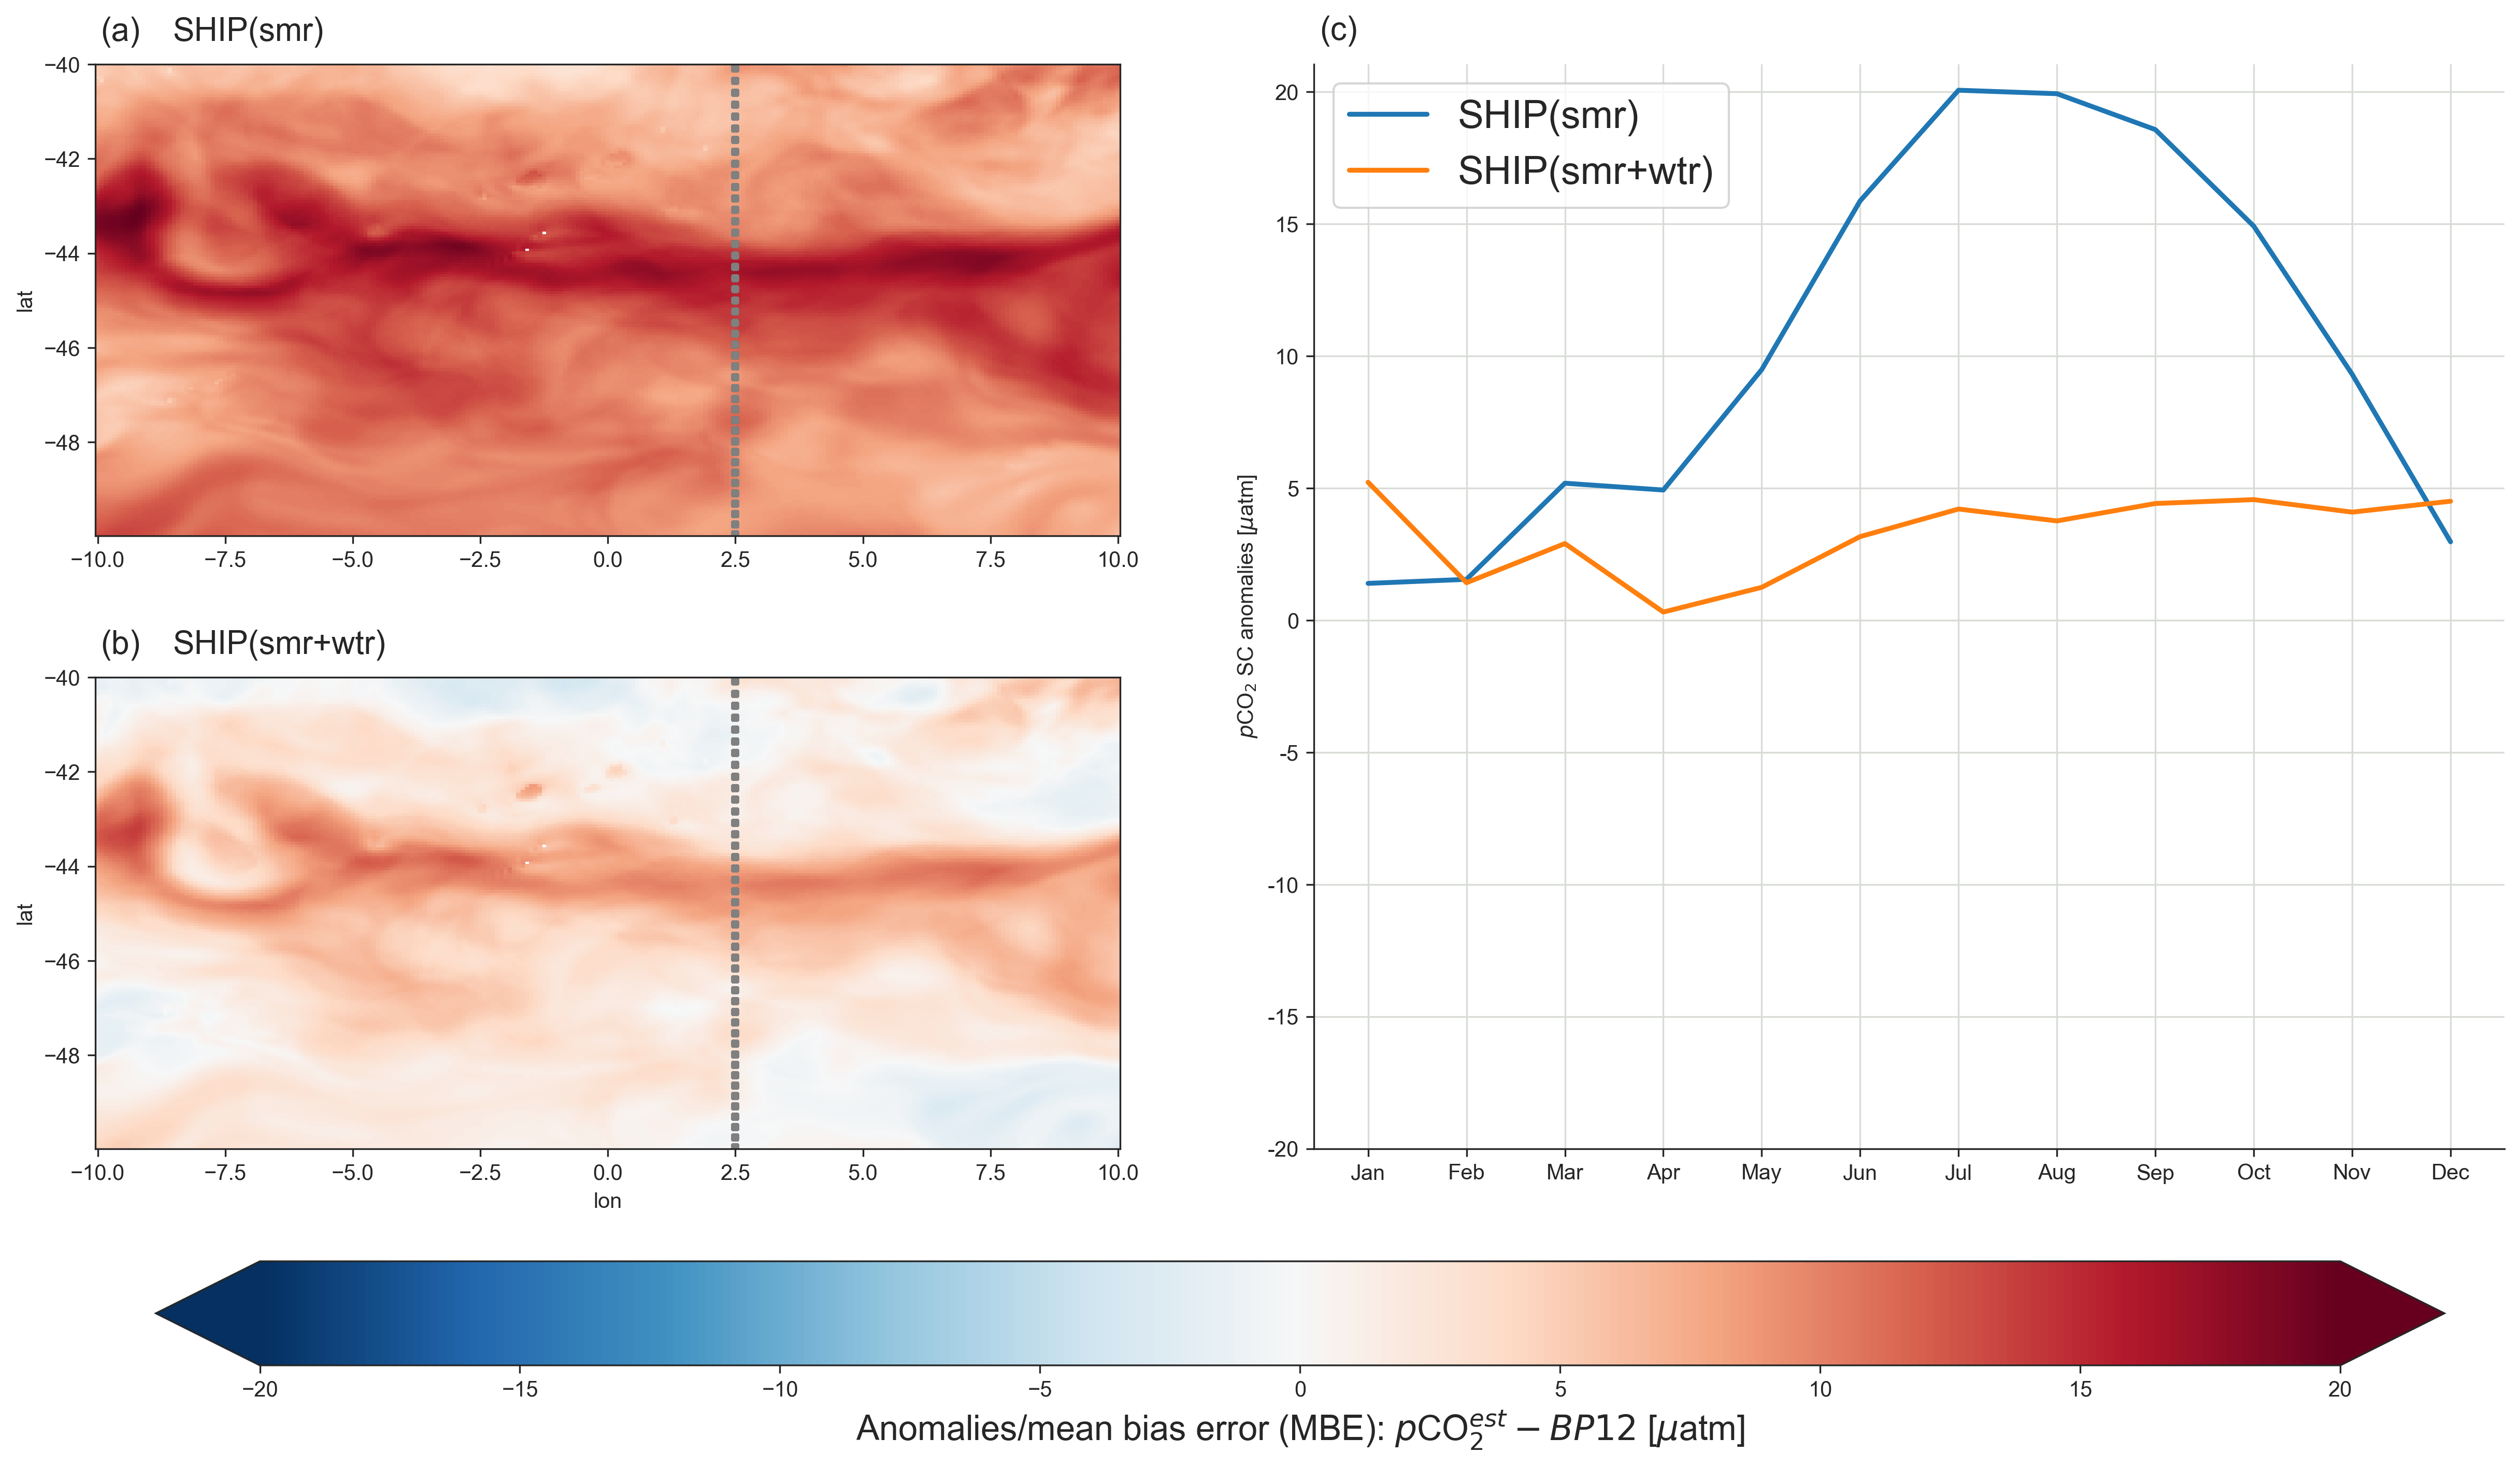

In [27]:
### Option 2: with the SHIP sampling line 
fig = anom_and_ships2(dict_expts, spco2_obs, ship_tracks,
                      yaxis_scale=20, ftsize=15, ncols=1, lgdsize=18)

### Save the figure
# sfig = "spCO2_estimate_annual_mean_and_seasonal_cycle_anomalies_ship_osse_paper1.pdf"
# fig.savefig(f"./figures/{sfig}", bbox_inches="tight", dpi=300)

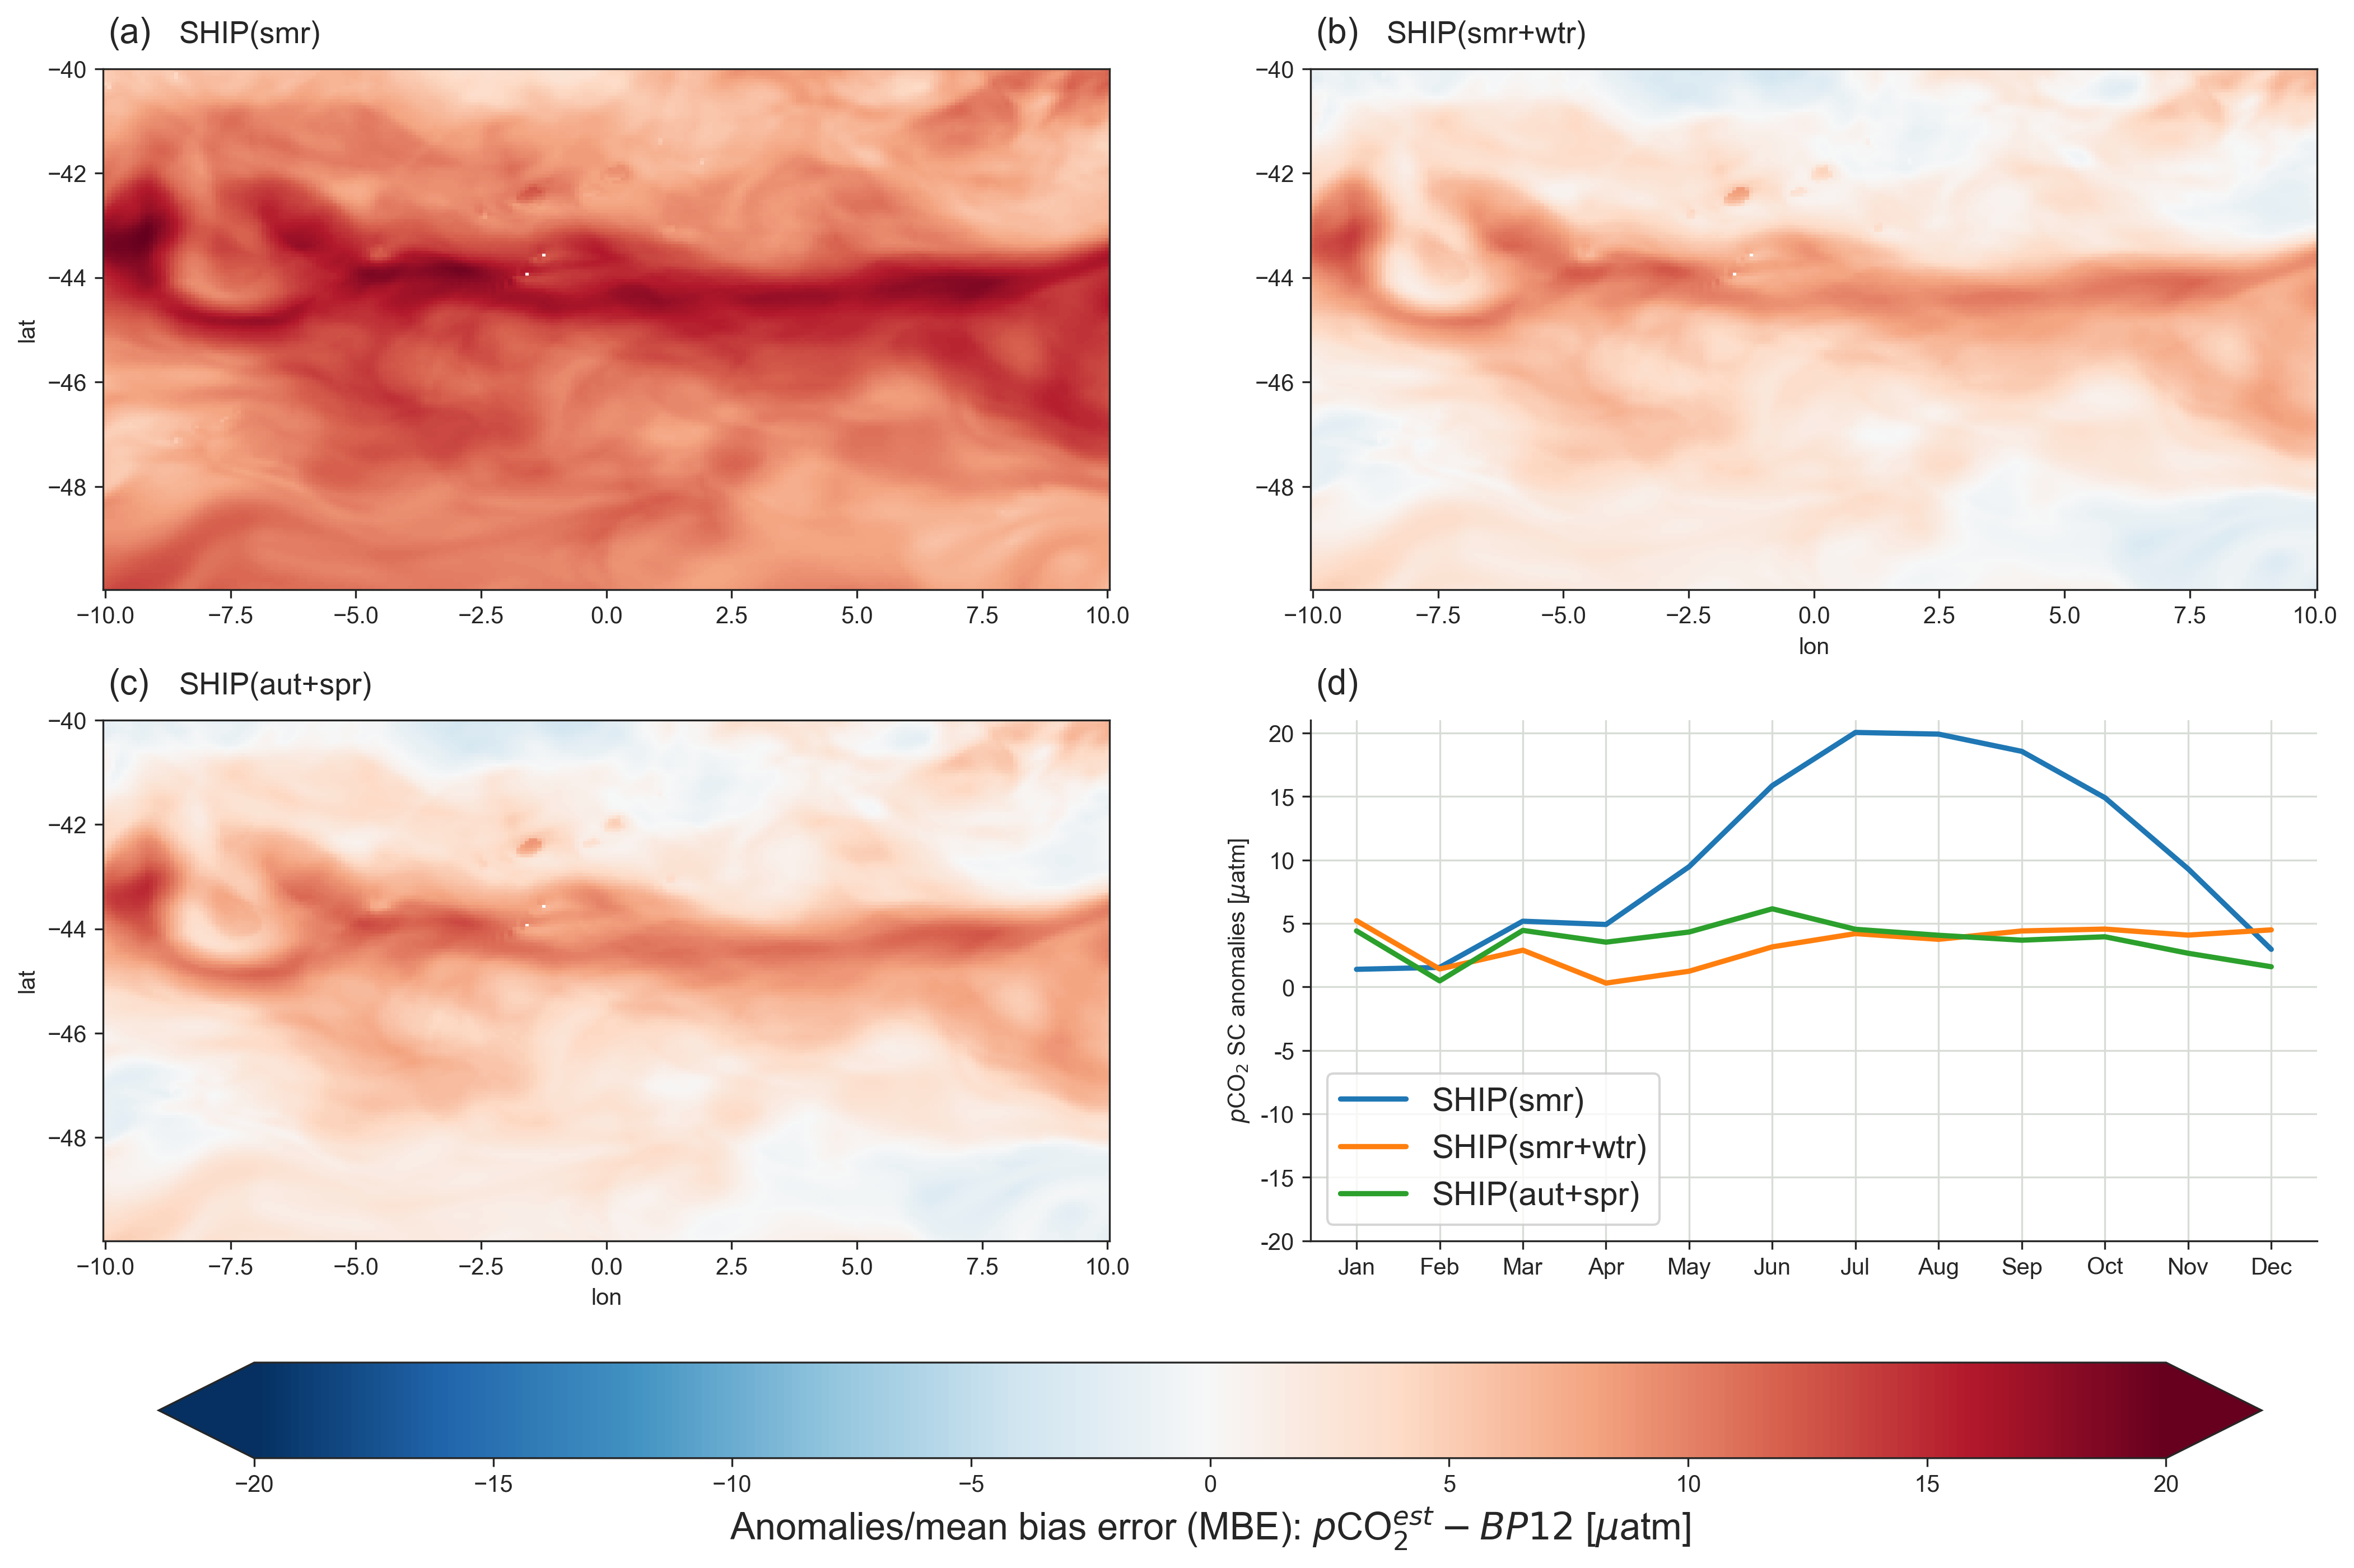

In [28]:
###### Required data 
dict_expts = {"SHIP(smr)": spco2_est.sel(experiment="SHIP(smr)").drop(["experiment"]),
              "SHIP(smr+wtr)": spco2_est.sel(experiment="SHIP(smr+wtr)").drop(["experiment"]),
              "SHIP(aut+spr)": spco2_est.sel(experiment="SHIP(aut+spr)").drop(["experiment"])}

### Plot
fig = anom_and_ships3(dict_expts, yaxis_scale=20, lgdsize=14)

### Save the figure
# sfig = "spCO2_estimate_annual_mean_and_seasonal_cycle_anomalies_ship_osse_paper1_supplement.pdf"
# fig.savefig(f"./figures/{sfig}", bbox_inches="tight", dpi=300)

#### SHIP(smr) + WG/FLOAT/nUSV experiments

In [29]:
def anom_and_ships3(dict_expts, spco2_obs,
                    cbr_limit=20, yaxis_scale=20,
                    ftsize=12, ncols=2, lgdsize=9):
    ### Limits
    
    ### Make a user-defined colormap: Red-White-Blue palette
    #BuWiRed = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName", ["b", "w", "r"])
    BuWiRed = "RdBu_r"
    ### Make a normalizer that will map the time values
    cnorm = mpl.colors.Normalize(vmin=-cbr_limit, vmax=cbr_limit)
    #### Turn these into an object that can be used to map time values to colors and
    # can be passed to plt.colorbar().
    cpick = mpl.cm.ScalarMappable(norm=cnorm, cmap=BuWiRed)
    cpick.set_array([])
    
    #fig = plt.figure(figsize=[17,12], dpi=300)
    fig = plt.figure(figsize=[24, 24], dpi=300, constrained_layout=True)
    grid = mpl.gridspec.GridSpec(4, 3, wspace=0.178, hspace=0.3)
    ax1 = fig.add_subplot(grid[0, 0])
    ax2 = fig.add_subplot(grid[0, 1])
    ax3 = fig.add_subplot(grid[1, 0])
    ax4 = fig.add_subplot(grid[1, 1])
    ax5 = fig.add_subplot(grid[2, 0])
    ax6 = fig.add_subplot(grid[2, 1])
    ax7 = fig.add_subplot(grid[3, 0])
    ax8 = fig.add_subplot(grid[3, 1])
    
    ax = [ax1, ax3, ax4, ax5, ax6, ax7, ax8]
    num_fig = ["a", "c", "d", "e", "f", "g", "h"]
    
    ### Optional params. for plotting
    kwargs = dict(add_colorbar=False, vmin=-cbr_limit, vmax=cbr_limit, cmap=BuWiRed)
    
    sc_anoms = {}
    imgs = []
    for i, expt in enumerate(dict_expts.keys()):
        xda_mbe = get_mbe(spco2_obs, dict_expts[expt])
        img = xda_mbe.plot.pcolormesh(ax=ax[i], **kwargs)
        imgs.append(img)
        sc_anoms[expt] = get_sc_anom(spco2_obs, dict_expts[expt])
        ax[i].axes.axis('tight')
        ax[i].set_xlabel("")
        ax[i].set_ylabel("")
        start, end = ax1.get_ylim()
        ax[i].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%0.0f"))
        ax[i].yaxis.set_ticks(np.arange(round(start), round(end)+0.01, 2.0))

    cbr = fig.colorbar(cpick, ax=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8],
                       orientation="horizontal",
                       extend="both", shrink=0.95, pad=0.04)
    cbr.set_label("Anomalies/mean bias error (MBE): $p$CO$_{2}^{est}-BP12$ [$\mu$atm]", fontsize=17)
    ax[0].set_ylabel("lat")
    ax[1].set_ylabel("lat")
    ax[3].set_ylabel("lat")
    ax[5].set_xlabel("lon")
    ax[5].set_ylabel("lat")
    ax[6].set_xlabel("lon\n\n")
    
    ### Plot the SC anomalies
    df = pd.DataFrame(sc_anoms, index=sc_anoms[expt].index)
    pd.DataFrame(sc_anoms).plot(ax=ax2, lw=2.25)
    
    #start, end = ax2.get_ylim()
    ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%0.0f"))
    start, end = -yaxis_scale, yaxis_scale+1
    ax2.yaxis.set_ticks(np.arange(start, end, 5))
    ax2.set_ylabel("$p$CO$_2$ SC anomalies [$\mu$atm]")
    #
    ax2.xaxis.set_ticks(np.arange(df.shape[0]))
    ax2.set_xticklabels(df.index)
    ax2.set_xlabel("")
    ax2.grid(c="#d8dcd6")
    ax2.legend(ncol=ncols, loc=0, fontsize=lgdsize)
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
        
    #ax2.set_facecolor("#758da3");
    
    ### Number/label the graphs
    #number_figures(ax[:-1], pos=[0.005,1.05], braces=True)
    number_figures([ax1, ax3, ax4, ax5, ax6, ax7, ax8], pos=[0.005,1.05],
                   labels=num_fig, braces=True, ftsize=ftsize)
    number_figures([ax1, ax3, ax4, ax5, ax6, ax7, ax8], pos=[0.075,1.05],
                   labels=df.columns, braces=False, ftsize=ftsize)
    number_figures([ax2], pos=[0.005, 1.03], labels=["b"], braces=True)
    
    return fig

In [30]:
##### Required data 
dict_expts = {"SHIP(smr)": spco2_est.sel(experiment="SHIP(smr)").drop(["experiment"]),
              "SHIP(smr) + FLOAT(SAZ)": spco2_est.sel(experiment="SHIP(smr) + FLOAT(SAZ)").drop(["experiment"]),
              "SHIP(smr) + FLOAT(PFZ)": spco2_est.sel(experiment="SHIP(smr) + FLOAT(PFZ)").drop(["experiment"]),
              "SHIP(smr) + WG(SAZ)": spco2_est.sel(experiment="SHIP(smr) + WG(SAZ)").drop(["experiment"]),
              "SHIP(smr) + WG(PFZ)": spco2_est.sel(experiment="SHIP(smr) + WG(PFZ)").drop(["experiment"]),
              "SHIP(smr) + FLOAT(SAZ+PFZ)": spco2_est.sel(experiment="SHIP(smr) + FLOAT(SAZ+PFZ)").drop(["experiment"]),
              "SHIP(smr) + nUSV": spco2_est.sel(experiment="SHIP(smr) + nUSV").drop(["experiment"])}


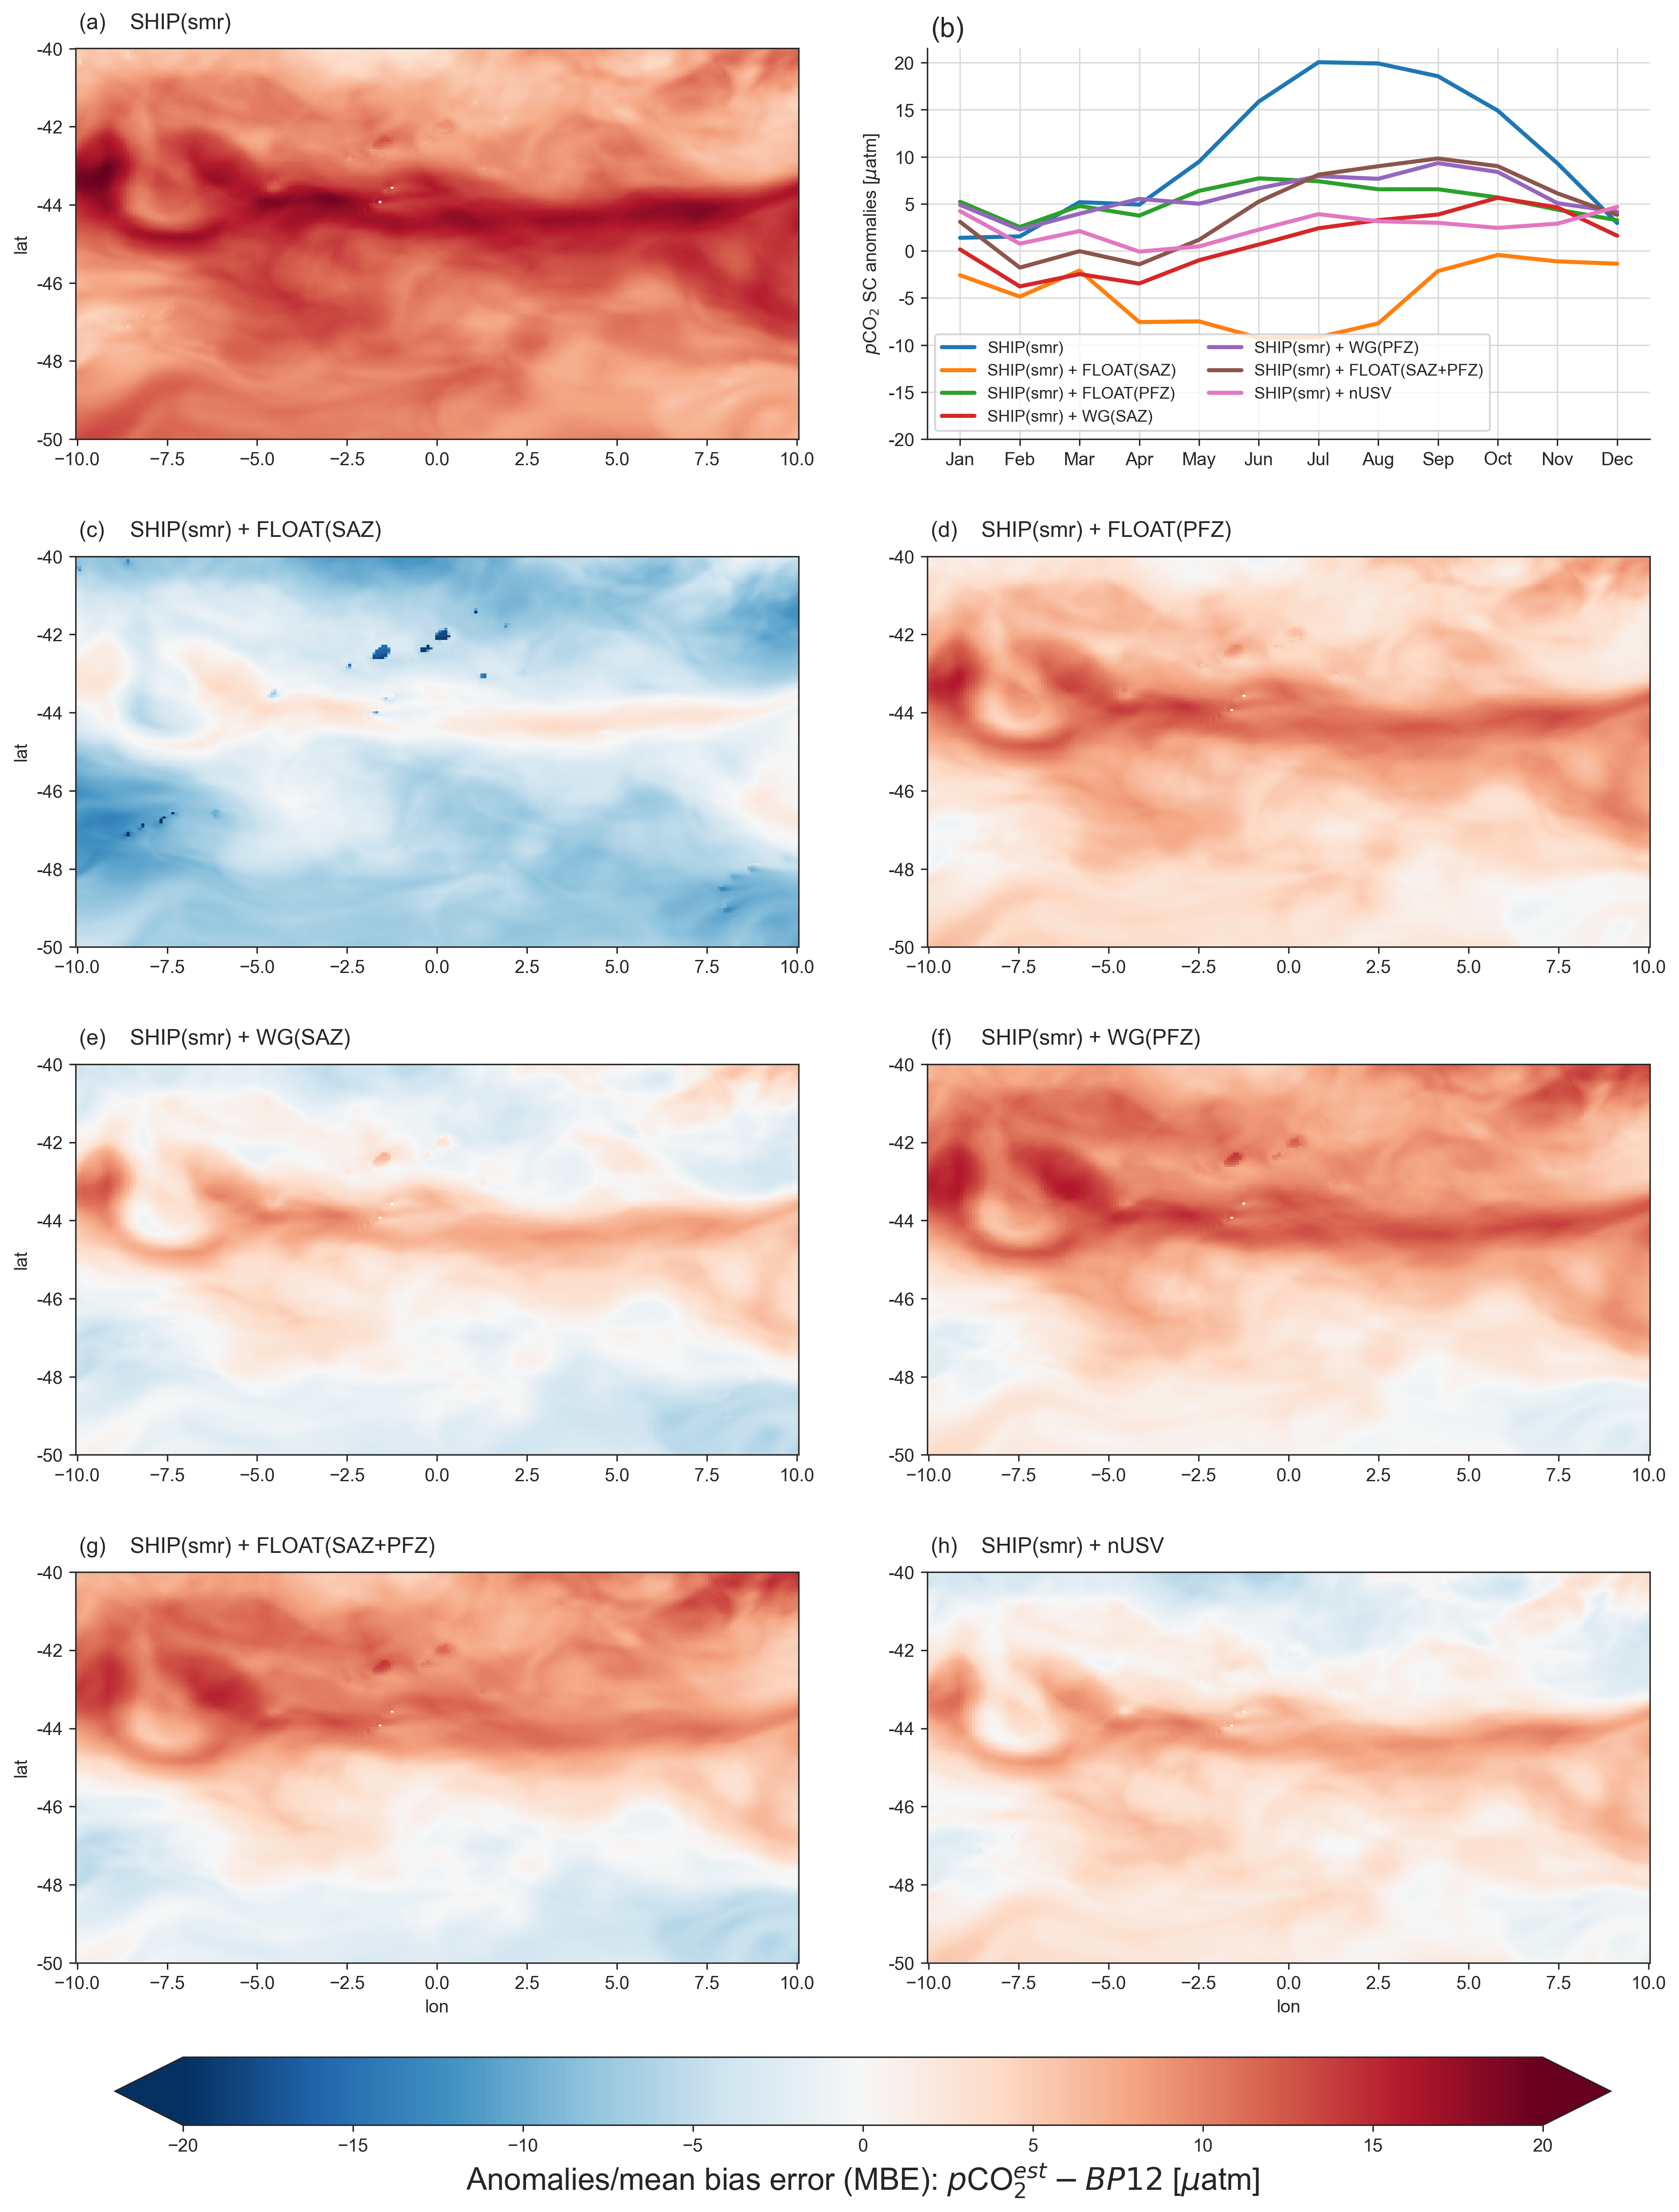

In [32]:
### Plot
fig = anom_and_ships3(dict_expts, spco2_obs)

### Save the figure
# sfig = "spCO2_estimate_annual_mean_and_seasonal_cycle_anomalies_osse_paper1.pdf"
# fig.savefig(f"./figures/{sfig}", bbox_inches="tight", dpi=300)

#### SHIP experiment across sub-domains

In [34]:
### Split the BP12 model pCO2 into SAZ and PFZ 
saz_spco2_obs, pfz_spco2_obs = split_data_saz_pfz(xds=spco2_obs)

In [35]:
####### Get the required data for SUMMER  
### Split the data into SAZ and PFZ
xds = spco2_est.sel(experiment="SHIP(smr)").drop(["experiment"])
saz_spco2_est_smr, pfz_spco2_est_smr = split_data_saz_pfz(xds=xds)

In [36]:
####### Get the required data for SUMMER  
### Split the data into SAZ and PFZ
xds = spco2_est.sel(experiment="SHIP(smr+wtr)").drop(["experiment"])
saz_spco2_est_smr_wtr, pfz_spco2_est_smr_wtr = split_data_saz_pfz(xds=xds)

In [37]:
### Regroup the data  

dict_expts = {"SHIP (summer)": spco2_est.sel(experiment="SHIP(smr)").drop(["experiment"]),
              "SHIP (summer+winter)": spco2_est.sel(experiment="SHIP(smr+wtr)").drop(["experiment"])}

sc_anom_dom = {expt: get_sc_anom(spco2_obs,
                                 dict_expts[expt]) for expt in dict_expts.keys()}

dict_expts = {"SHIP (summer)": [saz_spco2_obs, saz_spco2_est_smr],
              "SHIP (summer+winter)": [saz_spco2_obs, saz_spco2_est_smr_wtr]}

sc_anom_saz = {expt: get_sc_anom(dict_expts[expt][0],
                                 dict_expts[expt][1]) for expt in dict_expts.keys()}

dict_expts = {"SHIP (summer)": [pfz_spco2_obs, pfz_spco2_est_smr],
              "SHIP (summer+winter)": [pfz_spco2_obs, pfz_spco2_est_smr_wtr]}

sc_anom_pfz = {expt: get_sc_anom(dict_expts[expt][0],
                                 dict_expts[expt][1]) for expt in dict_expts.keys()}

sc_anoms_ship = {"domain": sc_anom_dom,
                 "SAZ": sc_anom_saz,
                 "PFZ": sc_anom_pfz}

dom_colors = {"domain": "#1b2431",
              "SAZ": "#1d5dec",
              "PFZ": "#fe420f"}



In [38]:
def plot_ship_sc_anom(cbar=True): 
    fig = plt.figure(figsize=[16, 5.5], dpi=300, constrained_layout=True)
#     grid = mpl.gridspec.GridSpec(1, 2, wspace=0.05, hspace=0.3, width_ratios=[1.85, 2.15])
    grid = mpl.gridspec.GridSpec(1, 2, wspace=0.05, hspace=0.3)
    ax1 = fig.add_subplot(grid[0, 0])
    ax2 = fig.add_subplot(grid[0, 1], sharey=ax1)
    ### Make a user-defined colormap: Red-White-Blue palette
    BuWiRed = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName", ["b", "w", "r"])
    ax = [ax1, ax2]
    lgdsize = 15
    ncols = 1
    ftsize = 15
    vmin_, vmax_ = -20, 20
    for region in sc_anoms_ship:
        for i, key in enumerate(sc_anoms_ship[region]):
            sc_anoms_ship[region][key].plot(ax=ax[i], lw=2.25, c=dom_colors[region], label=region)

            #start, end = ax[-1].get_ylim()
            ax[i].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%0.0f"))
            start, end = vmin_, vmax_+1
            ax[i].yaxis.set_ticks(np.arange(start, end, 5))
            ax[i].set_ylabel("")
            #
            ax[i].set_xlabel("")
            ax[i].grid(c="#d8dcd6")
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].legend(ncol=ncols, loc=0, fontsize=lgdsize)
            ax[i].axes.axis('tight')
            #ax[i].set_yticklabels([])


#     if cbar:
#         cb = fig.colorbar(sc_img, extend="both", orientation="vertical")
#         cb.set_label("$p$CO$_2$ SC anomalies [$\mu$atm]", fontsize=13)
    #ax[-1].set_facecolor("#758da3");
    #ax[i].set_xlabel("")
    ax[0].set_ylabel("$p$CO$_2$ SC anomalies [$\mu$atm]")

    df = pd.DataFrame(sc_anoms_ship[region], index=sc_anoms_ship[region][key].index)
    [a.xaxis.set_ticks(np.arange(df.shape[0])) for a in ax]
    [a.set_xticklabels(df.index) for a in ax]
    ### Number/label the graphs
    number_figures(ax, pos=[0.005,1.05], braces=True)
    number_figures(ax, pos=[0.075,1.05], labels=df.columns, ftsize=ftsize, braces=False)

    return fig

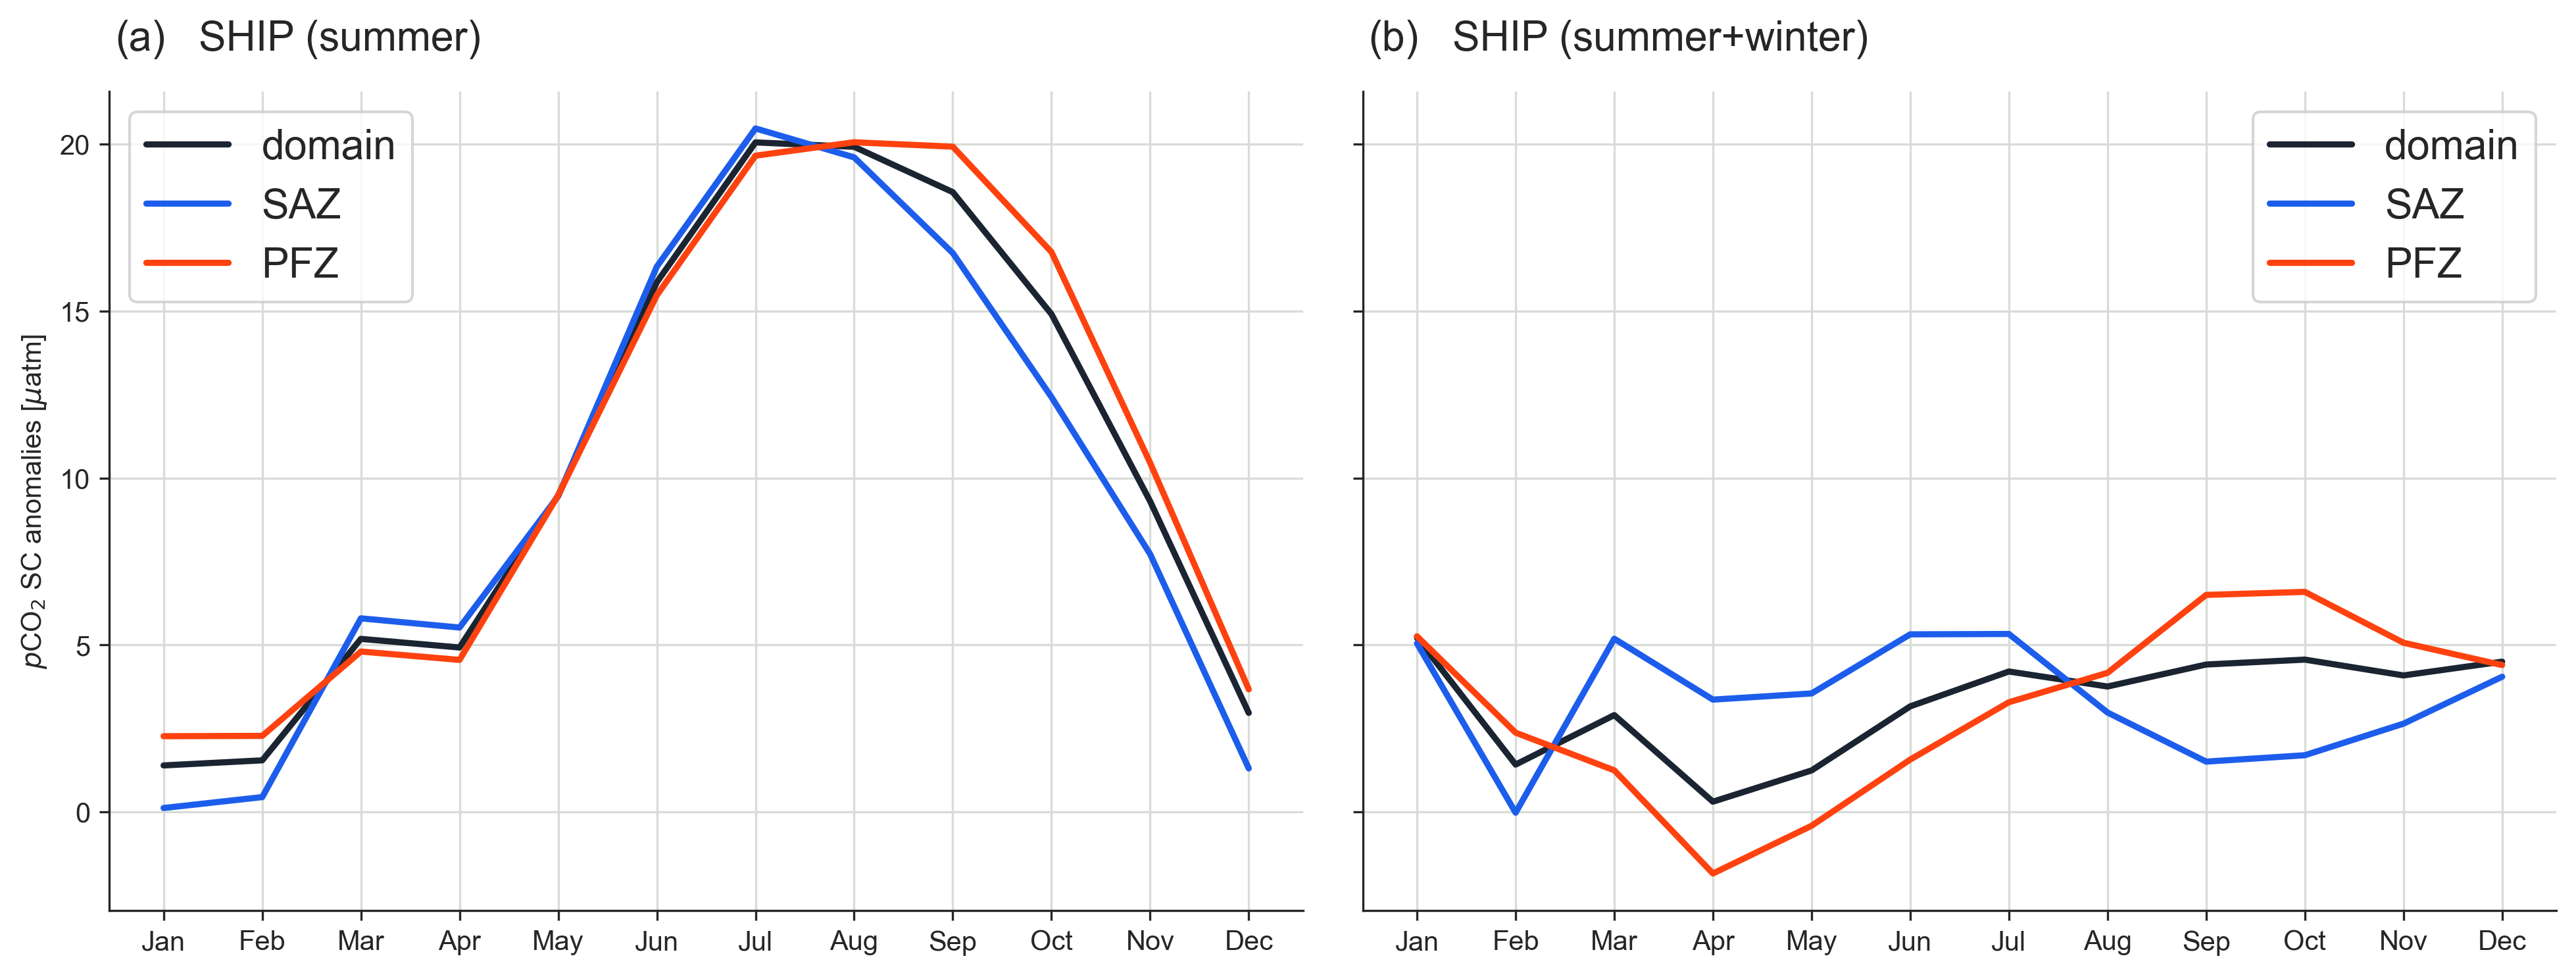

In [39]:
##### Plot the pCO2 SC anom. for the SHIP expt  
fig = plot_ship_sc_anom()

### Save the figure
# sfig = "spCO2_estimate_seasonal_cycle_anomalies_per_subdomain_ship_osse_paper1.pdf"
# fig.savefig(f"./figures/{sfig}", bbox_inches="tight", dpi=300)

### Meridional Gradient (MG) of $p\text{CO}_2$ 

#### Tools

In [40]:
def highlight_ship(pos, ax, color="k"):
    ax.scatter(pos[:,0], pos[:,1], marker=">", s=100, c=color)

In [41]:
def make_sc_mg(xda):
    return xda.groupby("time.month").mean("time").mean(["lon"])

In [42]:
def plot_sc_mg(xda, ax=None, fig=None):
    if (ax==None) and (fig==None):
        fig, ax = plt.subplots(figsize=(12, 5), dpi=100)

    kwargs = dict(add_colorbar=False, robust=True, vmin=350,
                  cmap="turbo", norm=mpl.colors.PowerNorm(gamma=1), zorder=-1)
    sc_mg_img = make_sc_mg(xda).plot(ax=ax, **kwargs)

    start, end = -50, -40
    ax.xaxis.set_ticks(np.arange(start, end+1, 1))
    xlabels = [-1*item for item in np.arange(start, end+1, 1)]
    ax.set_xticklabels([str(int(label))+"$^{\circ}$S" for label in xlabels])
    ax.set_xlabel("")

    ax.yaxis.set_ticks(np.arange(1, 13, 1))
    ylabels = xda.time.dt.month.to_dataframe().drop_duplicates().index.strftime("%b").values
    ax.set_yticklabels(ylabels)
    ax.set_ylabel("")

    cb = fig.colorbar(sc_mg_img, extend="max", orientation="vertical")
    cb.set_label("Surface Ocean $p$CO$_2$ [$\mu$atm]", fontsize=13);
    
    return fig

In [43]:
def plot_mg(mg_dict, wtr_col="#021bf9",
            smr_col="#9900fa", ax=None, fig=None, aut_lgd=True):
    
    if (ax==None) and (fig==None):
        fig, ax = plt.subplots(figsize=(8, 4.5), dpi=100)
    
    cols = ["k", wtr_col, smr_col]
    for idx, key in enumerate(mg_dict.keys()):
        mg_dict[key].plot(ax=ax, c=cols[idx], lw=5.25)
    
    ax.axvspan(-50, -46.75, alpha=0.1, color="#929591")
    ax.axvspan(-42.75, -40, alpha=0.1, color="#929591")
    ax.set_ylabel("Surface ocean $p$CO$_{2}$ [$\mu$atm]")
    labels = ["mean annual",
              "along the SHIP line in Jul (wtr)",
              "along the SHIP line in Jan (smr)"]
    
    if aut_lgd:
        ax.legend(labels=labels, loc=0, ncol=1,
                  frameon=False, shadow=False,
                  fontsize=12)
    else:
        ax.legend(labels=labels, bbox_to_anchor=(0.39, 0.67, 0, 0), ncol=1,
                  frameon=False, shadow=False,
                  fontsize=12)
    
    ax.set_ylim(350)
    #ax.grid()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    start, end = -50, -40
    ax.xaxis.set_ticks(np.arange(start, end+1, 1))
    xlabels = [-1*item for item in np.arange(start, end+1, 1)]
    ax.set_xticklabels([str(int(label))+"$^{\circ}$S" for label in xlabels])
    ax.set_xlabel("")

    return fig

In [44]:
def get_single_grid_cell(xda, subdomain="SAZ"):
    
    if subdomain=="SAZ":
        ### 42ºS (SAZ) 
        grid = dict(lat=slice(-42.1, -42.0), lon=slice(2.2, 2.25))
    elif subdomain=="SAF":
        ### 44ºS (SAF)
        grid = dict(lat=slice(-44.1, -44.0), lon=slice(2.2, 2.25))
        
    elif subdomain=="PFZ":
        ### 47ºS (PFZ)
        grid = dict(lat=slice(-47.2, -47.0), lon=slice(2.2, 2.25))
        
    out = xda.sel(**grid).mean(["lat", "lon"]).to_dataframe().reset_index().set_index("time")
    return out

#### Make the mean annual MG of $p\text{CO}_2$

In [45]:
### Calculate the mean annual meridional gradient of pCO2 
mean_ann_mg_spco2 = spco2_obs.mean(["lon", "time"], keep_attrs=True)

#### MG of $p\text{CO}_2$ along the SHIP line ($\sim 2.5^{\circ}\text{S}$) in summer (Jan) and winter (July)

In [46]:
### In summer (Jan) 
jan_mg_spco2 = spco2_obs.sel(time=slice("2008-01", "2008-01"),
                             lon=slice(2.5, 2.5)).mean(["lon", "time"], keep_attrs=True)

### In winter (Jul) 
jul_mg_spco2 = spco2_obs.sel(time=slice("2008-07", "2008-07"),
                             lon=slice(2.5, 2.5)).mean(["lon", "time"], keep_attrs=True)

#### Plot the meridional gradient of $p\text{CO}_2$


In [47]:
#### Data: meridional gradient of pCO2 
mg_dict = {"mn_ann_mg": mean_ann_mg_spco2,
           "mn_jul_mg": jul_mg_spco2,
           "mn_jan_mg": jan_mg_spco2}

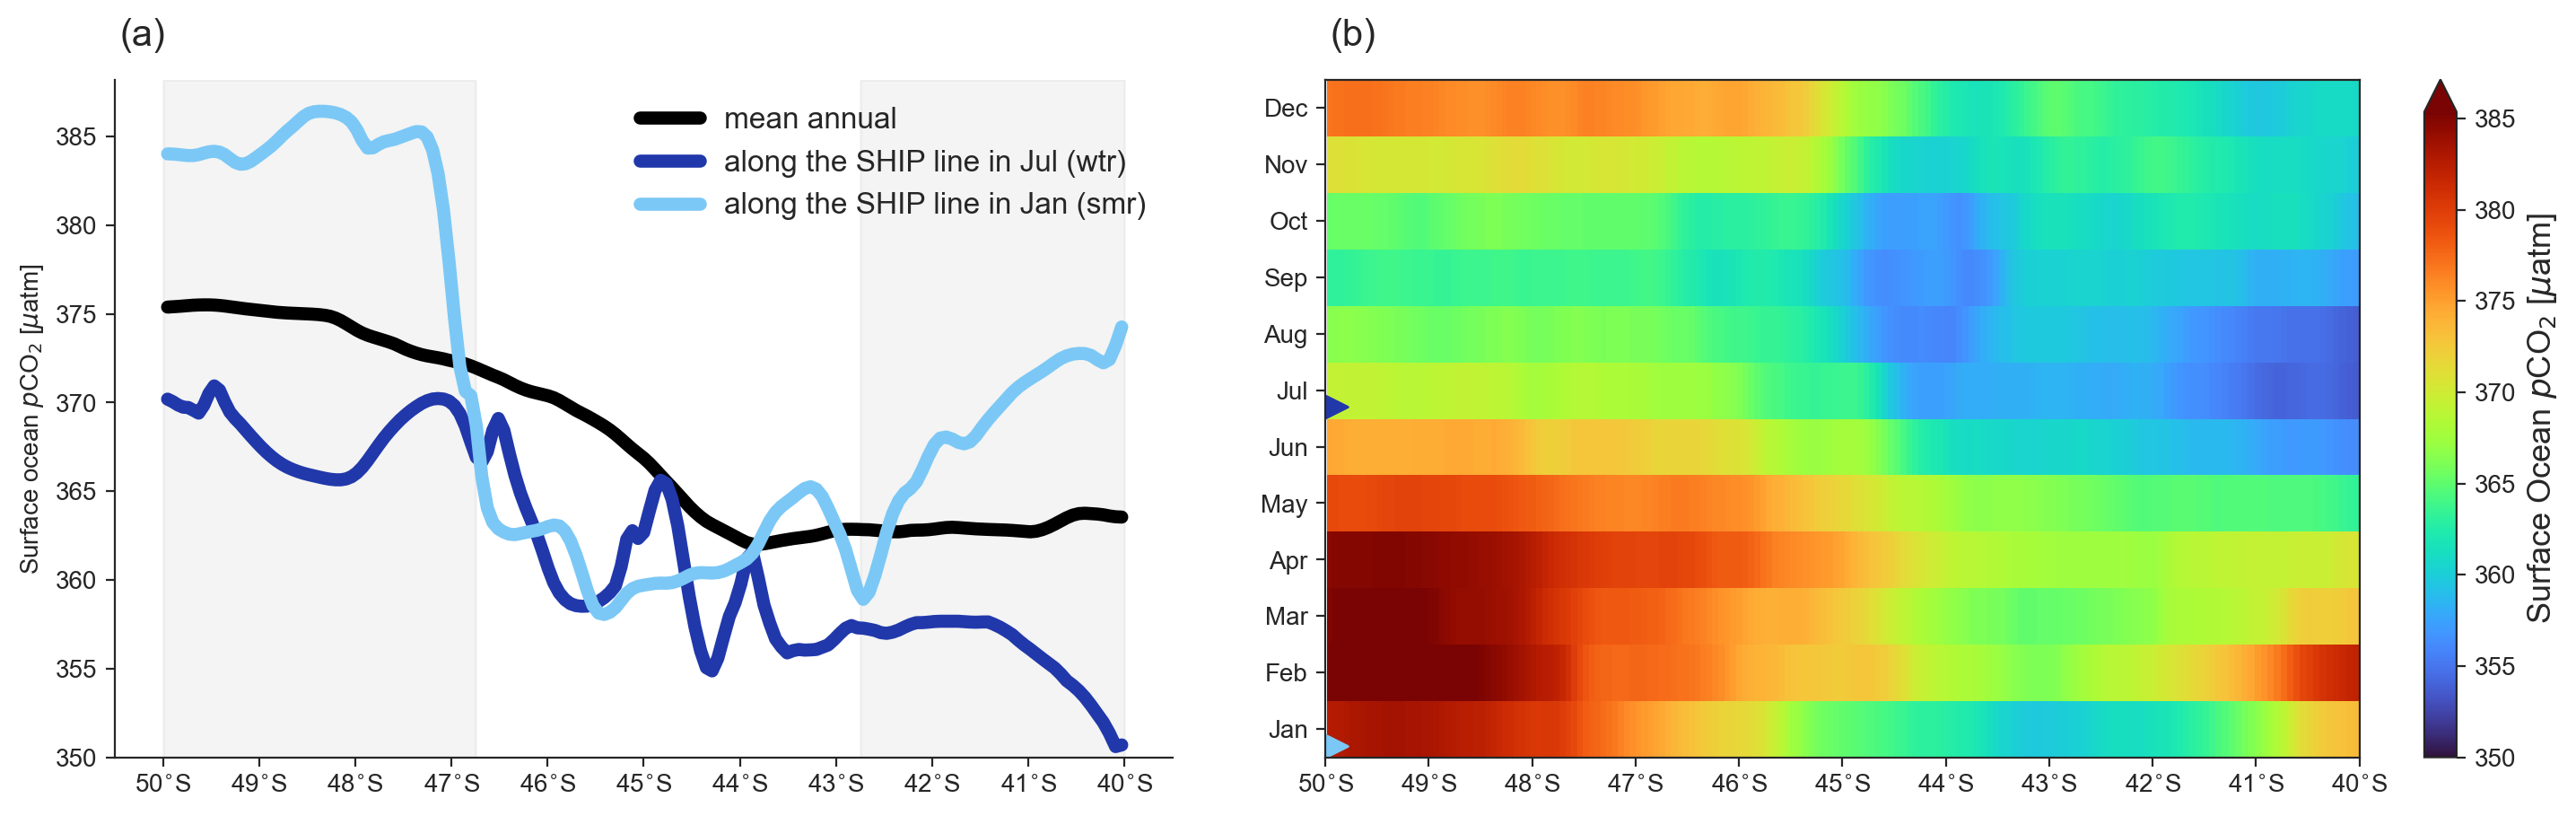

In [48]:
##### Plot 
fig = plt.figure(figsize=[18, 5], dpi=200, constrained_layout=True)
grids = mpl.gridspec.GridSpec(1, 2, wspace=0.13, width_ratios=[1.8, 2.2])
ax = [fig.add_subplot(grids[0]),
      fig.add_subplot(grids[1])]

wtr_col = "#2138ab"
smr_col = "#7bc8f6"
fig = plot_mg(mg_dict, wtr_col=wtr_col,
              smr_col=smr_col, ax=ax[0], fig=fig)
fig = plot_sc_mg(spco2_obs, ax[1], fig)
### Highlight ship sample
winter = np.array([[-49.91, 6.7]])
summer = np.array([[-49.91, 0.7]])
highlight_ship(winter, ax[1], color=wtr_col)
highlight_ship(summer, ax[1], color=smr_col)

### Label 
number_figures(ax[:], pos=[0.005,1.05], braces=True)

### Save the figure
# sfig = "meridional_gradients_spCO2_and_ship_line_osse_paper1.pdf"
# fig.savefig(f"./figures/{sfig}", bbox_inches="tight", dpi=300)

#### Intra-seasonal scale variability per sub-domain

In [49]:
### 42ºS (SAZ) 
ts_spco2_saz = get_single_grid_cell(spco2_obs, subdomain="SAZ")

### 44ºS (SAF)
ts_spco2_saf = get_single_grid_cell(spco2_obs, subdomain="SAF")

### 47ºS (PFZ)
ts_spco2_pfz = get_single_grid_cell(spco2_obs, subdomain="PFZ")

### Data --> df 
df_spco2 = pd.DataFrame(data = {"saz": ts_spco2_saz.values.reshape(-1),
                                "saf": ts_spco2_saf.values.reshape(-1),
                                "pfz": ts_spco2_pfz.values.reshape(-1)},
                        index=ts_spco2_saz.index.day_of_year)


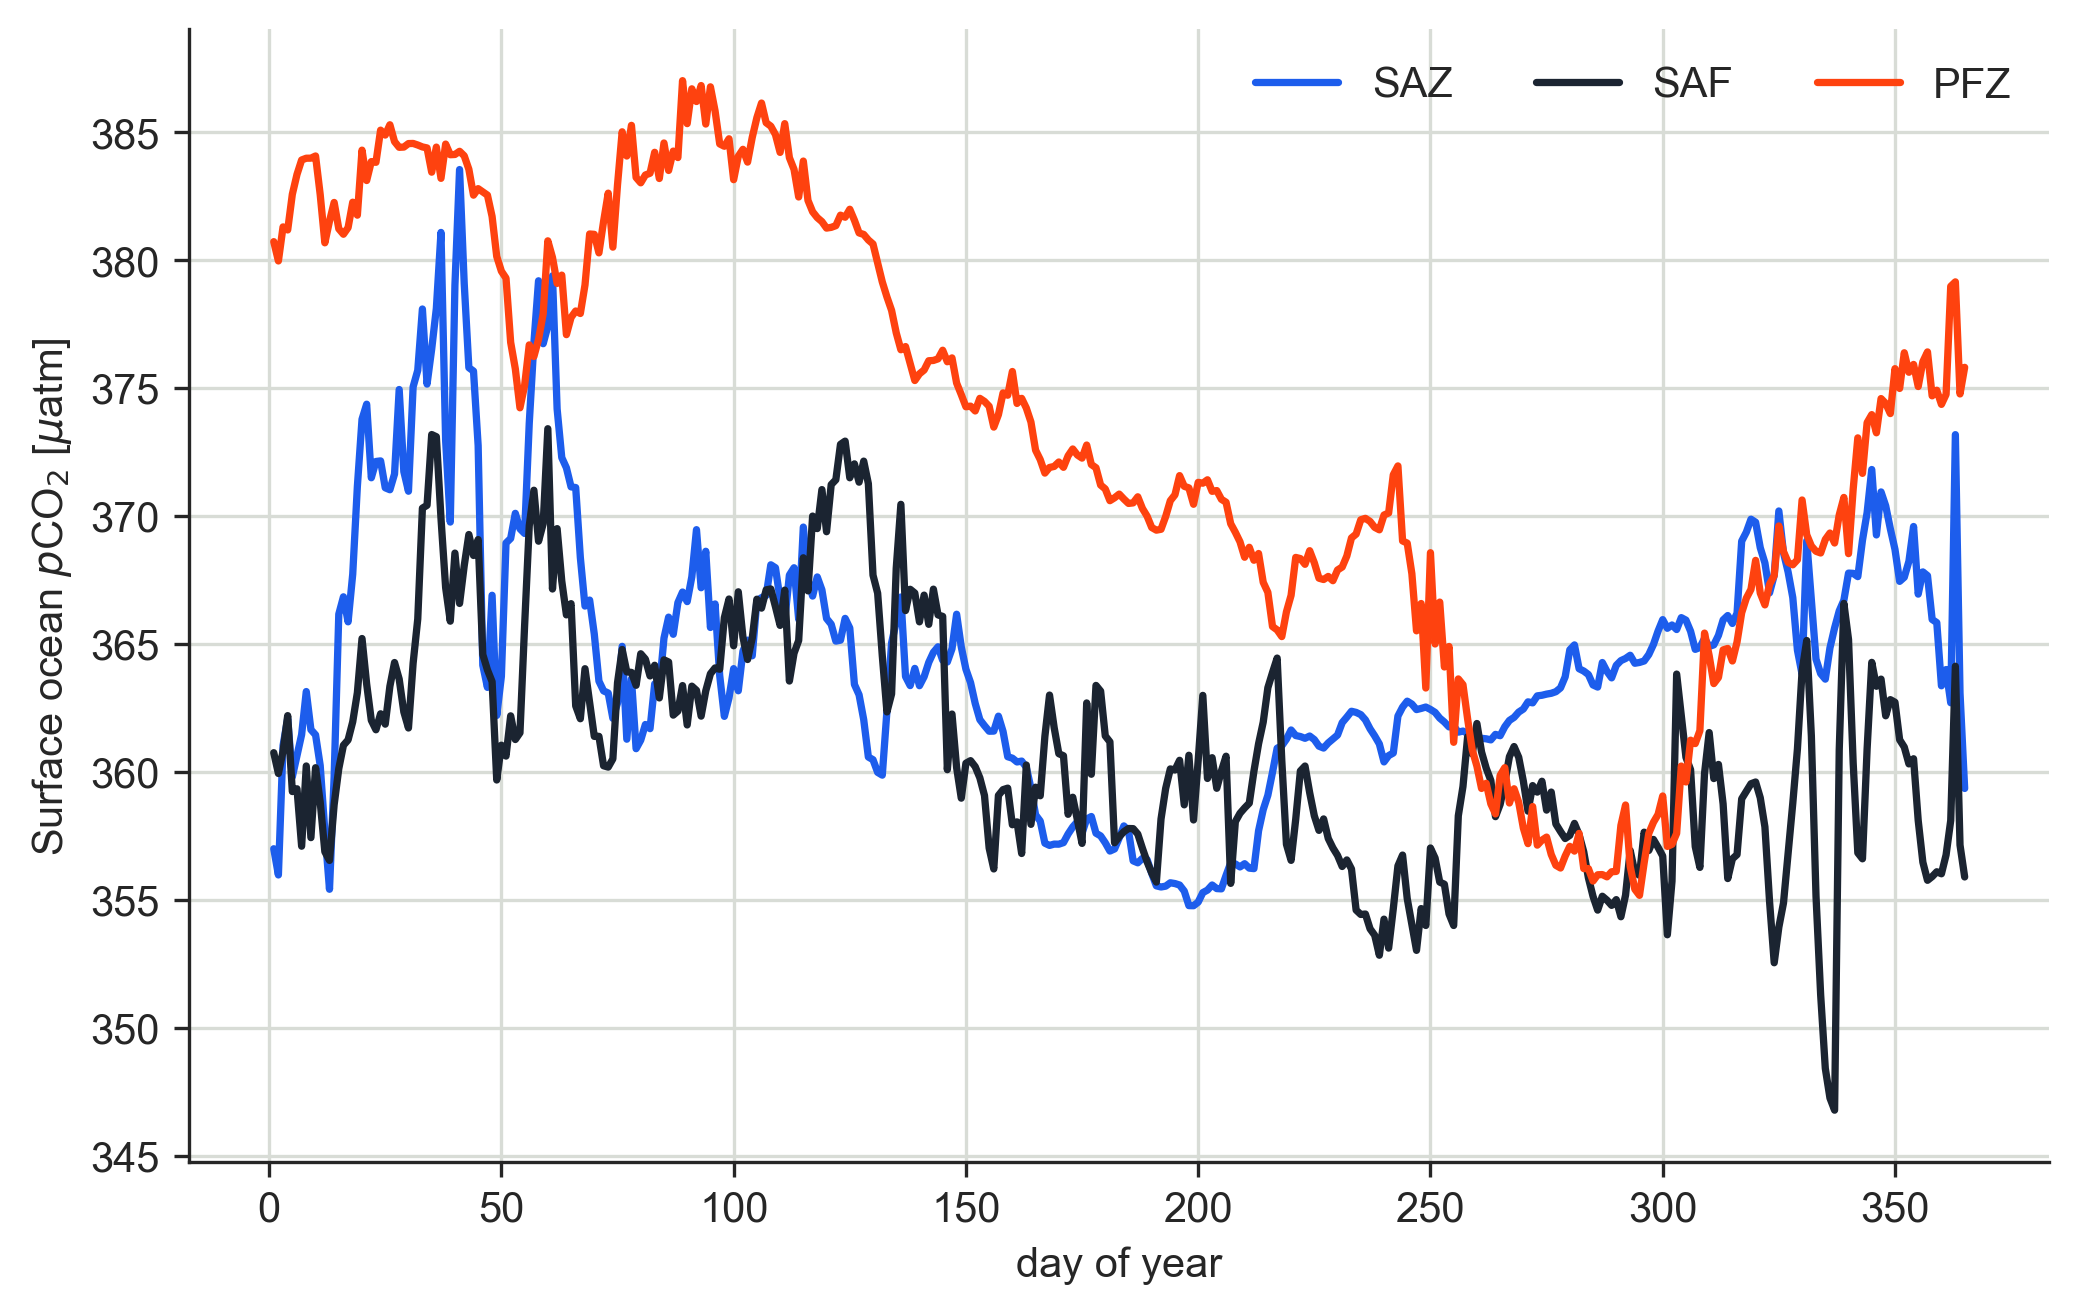

In [50]:
#### Time series plots of selected grid cells inside SAZ, SAF, and PFZ 
fig, ax = plt.subplots(figsize=[8,5], dpi=300)

### pCO2
df_spco2.saz.plot(ax=ax, lw=1.75, color="#1d5dec", label="SAZ")
df_spco2.saf.plot(ax=ax, lw=1.75, color="#1b2431", label="SAF")
df_spco2.pfz.plot(ax=ax, lw=1.75, color="#fe420f", label="PFZ")
ax.set_ylabel("Surface ocean $p$CO$_2$ [$\mu $atm]")
ax.set_xlabel("day of year")
ax.legend(frameon=False, ncol=3)
ax.grid(c="#d8dcd6")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False);

### Save the figure
# sfig = "time_series_of_spCO2_per_subdomain_osse_paper1.pdf"
# fig.savefig(f"./figures/{sfig}", bbox_inches="tight", dpi=300)